In [1]:
import pandas as pd
import ast


# Abstract level CT annotation and evaluation

In [2]:
!pip install abbreviations

DEPRECATION: prodigy 1.11.8 has a non-standard dependency specifier srsly>=2.0.0<3.0.0. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of prodigy or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [3]:
import pandas as pd
from abbreviations import schwartz_hearst

In [4]:
pairs = schwartz_hearst.extract_abbreviation_definition_pairs(doc_text='The emergency room (ER) was busy')
pairs

{'ER': 'emergency room'}

In [11]:
annotated_files_path_prefix = "./predictions/"

In [12]:
hugging_face_model_name_biolink = "michiyasunaga/BioLinkBERT-base"
model_name_str_biolink = hugging_face_model_name_biolink.split("/")[1]

In [13]:
hugging_face_model_name_biobert = "dmis-lab/biobert-v1.1"
model_name_str_biobert = hugging_face_model_name_biobert.split("/")[1]

In [14]:
# read annotated target dataset 
ds_annotated_full = pd.read_csv("../data/annotated_data/data_splits/ct_neuro_test_merged_90.csv")
col_name_target_annot = "ner_manual_ct_target"
# select only relevant columns
df = ds_annotated_full[['nct_id', 'text', col_name_target_annot]]

In [15]:
biolinkbert_col = f'ner_prediction_{model_name_str_biolink}_normalized'
df_biolinkbert = pd.read_csv(annotated_files_path_prefix + f"ct_neuro_test_annotated_{model_name_str_biolink}_20230916.csv")[['nct_id', biolinkbert_col]]
df = pd.merge(df, df_biolinkbert, on='nct_id', how='left')

In [16]:
biobert_col = f'ner_prediction_{model_name_str_biobert}_normalized'
df_biobert = pd.read_csv(annotated_files_path_prefix + f"ct_neuro_test_annotated_{model_name_str_biobert}_20230916.csv")[['nct_id', biobert_col]]
df = pd.merge(df, df_biobert, on='nct_id', how='left')

In [17]:
df.head(10)

,nct_id,text,ner_manual_ct_target,ner_prediction_BioLinkBERT-base_normalized,ner_prediction_biobert-v1.1_normalized
0,NCT04849741,"A Phase 1-3, Double-Blind, Randomized, Placebo...","[(39, 46, 'CONTROL', 'Placebo'), (166, 172, 'D...","[(39, 46, 'CONTROL', 'placebo'), (166, 172, 'D...","[(39, 44, 'CONTROL', 'Place'), (44, 46, 'CONTR..."
1,NCT04576507,Effects of Repeated Cannabis Administration on...,"[(20, 28, 'OTHER', 'Cannabis'), (60, 64, 'COND...","[(20, 28, 'OTHER', 'cannabis'), (60, 64, 'COND...","[(20, 25, 'DRUG', 'Canna'), (25, 28, 'OTHER', ..."
2,NCT00261508,Efficacy And Safety Of Risperidone In The Trea...,"[(23, 34, 'DRUG', 'Risperidone'), (69, 86, 'CO...","[(23, 34, 'DRUG', 'risperidone'), (69, 86, 'CO...","[(23, 24, 'DRUG', 'R'), (24, 34, 'DRUG', '##is..."
3,NCT01495923,"Randomized, Double-blind, Comparative-effectiv...","[(77, 84, 'DRUG', 'Steroid'), (99, 109, 'DRUG'...","[(68, 95, 'OTHER', 'epidural steroid injection...","[(68, 79, 'OTHER', 'Epidural St'), (79, 84, 'D..."
4,NCT03150563,Effects of Different Intensities of Passive St...,"[(36, 61, 'OTHER', 'Passive Static Stretching'...","[(36, 61, 'PHYSICAL', 'passive static stretchi...","[(36, 61, 'PHYSICAL', 'Passive Static Stretchi..."
5,NCT05265377,Safety and Usability of the STELO Exoskeleton ...,"[(28, 45, 'OTHER', 'STELO Exoskeleton'), (61, ...","[(28, 45, 'PHYSICAL', 'stelo exoskeleton'), (6...","[(28, 33, 'OTHER', 'STELO'), (34, 45, 'PHYSICA..."
6,NCT03170856,The Effects of a Sub-maximal Exercise Program ...,"[(17, 45, 'PHYSICAL', 'Sub-maximal Exercise Pr...","[(17, 45, 'PHYSICAL', 'sub - maximal exercise ...","[(17, 45, 'PHYSICAL', 'Sub - maximal Exercise ..."
7,NCT01421056,"A Randomized, Placebo-Controlled, Multicenter ...","[(14, 21, 'CONTROL', 'Placebo'), (121, 129, 'D...","[(14, 21, 'CONTROL', 'placebo'), (121, 129, 'D...","[(14, 19, 'CONTROL', 'Place'), (19, 21, 'CONTR..."
8,NCT04446416,"An Open Label, Prospective, Pilot Study to Eva...","[(137, 151, 'OTHER', 'NaviFUS System'), (169, ...","[(137, 151, 'OTHER', 'navifus system'), (169, ...","[(137, 139, 'OTHER', 'Na'), (141, 151, 'OTHER'..."
9,NCT04212260,Strengthening Oropharyngeal Muscles as a Novel...,"[(0, 35, 'PHYSICAL', 'Strengthening Oropharyng...","[(0, 35, 'PHYSICAL', 'strengthening oropharyng...","[(0, 5, 'PHYSICAL', 'Stren'), (5, 35, 'PHYSICA..."


In [18]:
# TODO
#df_gpt = pd.read_csv("corpus/model_annotations/ct_neuro_test_annotated_GPT_20230408.csv")[['nct_id', 'gpt_predictions']]
#df = pd.merge(df, df_gpt, on='nct_id', how='left')

In [19]:
#df_gpt.head()

In [20]:
# aggregate annotations and sum up how often they were annotated
def extract_summary(annotation_list):
    annotation_list = eval(annotation_list)
    summary = {}
    for annotation in annotation_list:
        _, _, entity_type, entity_name = annotation
        entity_name = entity_name.lower()
        if entity_type not in summary:
            summary[entity_type] = {}
        if entity_name not in summary[entity_type]:
            summary[entity_type][entity_name] = 0
        summary[entity_type][entity_name] += 1
    return summary

In [21]:
df['summary_target_labels'] = df[col_name_target_annot].apply(extract_summary)

In [22]:
df.head(-5)

,nct_id,text,ner_manual_ct_target,ner_prediction_BioLinkBERT-base_normalized,ner_prediction_biobert-v1.1_normalized,summary_target_labels
0,NCT04849741,"A Phase 1-3, Double-Blind, Randomized, Placebo...","[(39, 46, 'CONTROL', 'Placebo'), (166, 172, 'D...","[(39, 46, 'CONTROL', 'placebo'), (166, 172, 'D...","[(39, 44, 'CONTROL', 'Place'), (44, 46, 'CONTR...","{'CONTROL': {'placebo': 1}, 'DRUG': {'ion373':..."
1,NCT04576507,Effects of Repeated Cannabis Administration on...,"[(20, 28, 'OTHER', 'Cannabis'), (60, 64, 'COND...","[(20, 28, 'OTHER', 'cannabis'), (60, 64, 'COND...","[(20, 25, 'DRUG', 'Canna'), (25, 28, 'OTHER', ...","{'OTHER': {'cannabis': 7, 'medicinal cannabis'..."
2,NCT00261508,Efficacy And Safety Of Risperidone In The Trea...,"[(23, 34, 'DRUG', 'Risperidone'), (69, 86, 'CO...","[(23, 34, 'DRUG', 'risperidone'), (69, 86, 'CO...","[(23, 24, 'DRUG', 'R'), (24, 34, 'DRUG', '##is...","{'DRUG': {'risperidone': 2, 'antipsychotic med..."
3,NCT01495923,"Randomized, Double-blind, Comparative-effectiv...","[(77, 84, 'DRUG', 'Steroid'), (99, 109, 'DRUG'...","[(68, 95, 'OTHER', 'epidural steroid injection...","[(68, 79, 'OTHER', 'Epidural St'), (79, 84, 'D...","{'DRUG': {'steroid': 3, 'gabapentin': 2}, 'CON..."
4,NCT03150563,Effects of Different Intensities of Passive St...,"[(36, 61, 'OTHER', 'Passive Static Stretching'...","[(36, 61, 'PHYSICAL', 'passive static stretchi...","[(36, 61, 'PHYSICAL', 'Passive Static Stretchi...","{'OTHER': {'passive static stretching': 1, 'mu..."
...,...,...,...,...,...,...
80,NCT00909012,Quantitative Requirements of Docosahexaenoic A...,"[(29, 49, 'DRUG', 'Docosahexaenoic Acid'), (87...","[(29, 49, 'DRUG', 'docosahexaenoic acid'), (87...","[(29, 49, 'DRUG', 'Docosahexaenoic Acid'), (87...","{'DRUG': {'docosahexaenoic acid': 2, 'dha': 7}..."
81,NCT04955249,Impact of Dexmedetomidine Supplemented Analges...,"[(10, 25, 'DRUG', 'Dexmedetomidine'), (52, 60,...","[(10, 25, 'DRUG', 'dexmedetomidine'), (52, 60,...","[(10, 25, 'DRUG', 'Dexmedetomidine'), (52, 60,...","{'DRUG': {'dexmedetomidine': 2}, 'CONDITION': ..."
82,NCT00252850,"A Phase I, Open-Label Study of CERE-120 (Adeno...","[(31, 39, 'OTHER', 'CERE-120'), (41, 96, 'OTHE...","[(31, 39, 'DRUG', 'cere - 120'), (41, 46, 'OTH...","[(31, 39, 'DRUG', 'CERE - 120'), (41, 74, 'DRU...","{'OTHER': {'cere-120': 3, 'adeno-associated vi..."
83,NCT02840643,Combined Constraint Therapy and Bimanual Thera...,"[(9, 27, 'PHYSICAL', 'Constraint Therapy'), (3...","[(0, 27, 'OTHER', 'combined constraint therapy...","[(0, 8, 'PHYSICAL', 'Combined'), (9, 27, 'PHYS...","{'PHYSICAL': {'constraint therapy': 1, 'bimanu..."


In [23]:
print(df['summary_target_labels'][6])

{'PHYSICAL': {'sub-maximal exercise program': 1, 'sub-maximal exercise protocol': 1}, 'CONDITION': {'concussion': 2}}


In [24]:
# Define a function to extract the unique conditions, drugs, and others from the 'ner_manual_final_annotated_ds' column
def extract_unique_entities_count(annotation_list, abbreviation_definition_pairs):
    unique_conditions = set()
    unique_drugs = set()
    unique_others = set()
    annotation_list = eval(annotation_list)
    for annotation in annotation_list:
        _, _, entity_type, entity_name = annotation
        if entity_name in abbreviation_definition_pairs:
            #print("Skipping entity {} as it is an ABBR".format(entity_name))
            continue
        entity_name = entity_name.lower()
        if entity_type == 'CONDITION':
            unique_conditions.add(entity_name)
        elif entity_type == 'DRUG':
            unique_drugs.add(entity_name)
        elif entity_type == 'OTHER':
            unique_others.add(entity_name)
    return len(unique_conditions), len(unique_drugs), len(unique_others)

def extract_unique_entities(annotation_list, abbreviation_definition_pairs, model="linkbert", keep_drug_interventions_only=True):
    unique_conditions = set()
    unique_interventions = set()
    interventions_type = set()
    annotation_list = eval(annotation_list)
    
    for annotation in annotation_list:
        _, _, entity_type, entity_name = annotation
        if entity_name.startswith("##"):
            continue ## THERE IS AN ISSUE WITH BIOBERT
        if (len(entity_name) == 1 or len(entity_name)==2) and model=="biobert":
            continue ## ASSUME TOKENIZER ERROR IN BIOBERT
        # REPLACE ABBREVIATIONS WITH FULL FORM
        if entity_name in abbreviation_definition_pairs:
            #print("Skipping entity {} as it is an ABBR".format(entity_name))
            entity_name = abbreviation_definition_pairs[entity_name] 
            #continue
        if entity_name.upper() in abbreviation_definition_pairs:
            #print("Skipping entity {} as it is an ABBR".format(entity_name))
            entity_name = abbreviation_definition_pairs[entity_name.upper()] 
        entity_name = entity_name.lower()
        if entity_type == 'CONDITION':
            unique_conditions.add(entity_name)
        elif keep_drug_interventions_only and entity_type == 'DRUG':
            unique_interventions.add(entity_name)
            interventions_type.add(entity_type)
        elif not keep_drug_interventions_only:
            unique_interventions.add(entity_name)
            interventions_type.add(entity_type)
        
    return "|".join(list(unique_conditions)), "|".join(list(unique_interventions)), "|".join(list(interventions_type))

# Placeholder function to demonstrate applying the Schwartz-Hearst algorithm (Replace with actual implementation)
def extract_abbreviation_definition_pairs(doc_text):
    pairs = schwartz_hearst.extract_abbreviation_definition_pairs(doc_text=doc_text)
    return pairs

# Create a new column 'abbreviation_definition_pairs' using the 'apply' function
df['abbreviation_definition_pairs'] = df['text'].apply(extract_abbreviation_definition_pairs)

# Apply the function to each row and create new columns 'num_unique_conditions', 'num_unique_drugs', and 'num_unique_others'
df['unique_conditions_target'], df['unique_interventions_target'], df['unique_interventions_type_target'] = zip(*df.apply(lambda row: extract_unique_entities(row[col_name_target_annot], row['abbreviation_definition_pairs']), axis=1))
df[f'unique_conditions_{model_name_str_biolink}_predictions'], df[f'unique_interventions_{model_name_str_biolink}_predictions'], df[f'unique_interventions_type_{model_name_str_biolink}_predictions'] = zip(*df.apply(lambda row: extract_unique_entities(row[biolinkbert_col], row['abbreviation_definition_pairs']), axis=1))
df[f'unique_conditions_{model_name_str_biobert}_predictions'], df[f'unique_interventions_{model_name_str_biobert}_predictions'], df[f'unique_interventions_type_{model_name_str_biobert}_predictions'] = zip(*df.apply(lambda row: extract_unique_entities(row[biobert_col], row['abbreviation_definition_pairs'], model="biobert"), axis=1))

df['num_unique_conditions'], df['num_unique_drugs'], df['num_unique_others'] = zip(*df.apply(lambda row: extract_unique_entities_count(row[col_name_target_annot], row['abbreviation_definition_pairs']), axis=1))


In [25]:
df.head(-5)

,nct_id,text,ner_manual_ct_target,ner_prediction_BioLinkBERT-base_normalized,ner_prediction_biobert-v1.1_normalized,summary_target_labels,abbreviation_definition_pairs,unique_conditions_target,unique_interventions_target,unique_interventions_type_target,unique_conditions_BioLinkBERT-base_predictions,unique_interventions_BioLinkBERT-base_predictions,unique_interventions_type_BioLinkBERT-base_predictions,unique_conditions_biobert-v1.1_predictions,unique_interventions_biobert-v1.1_predictions,unique_interventions_type_biobert-v1.1_predictions,num_unique_conditions,num_unique_drugs,num_unique_others
0,NCT04849741,"A Phase 1-3, Double-Blind, Randomized, Placebo...","[(39, 46, 'CONTROL', 'Placebo'), (166, 172, 'D...","[(39, 46, 'CONTROL', 'placebo'), (166, 172, 'D...","[(39, 44, 'CONTROL', 'Place'), (44, 46, 'CONTR...","{'CONTROL': {'placebo': 1}, 'DRUG': {'ion373':...",{},axd.|alexander disease,ion373,DRUG,axd|alexander disease,ion373,DRUG,axd|alexander disease,ion373,DRUG,2,1,0
1,NCT04576507,Effects of Repeated Cannabis Administration on...,"[(20, 28, 'OTHER', 'Cannabis'), (60, 64, 'COND...","[(20, 28, 'OTHER', 'cannabis'), (60, 64, 'COND...","[(20, 25, 'DRUG', 'Canna'), (25, 28, 'OTHER', ...","{'OTHER': {'cannabis': 7, 'medicinal cannabis'...","{'THC': 'tetrahydrocannabinol', 'CBD': 'cannab...",pain|chronic pain,cannabidiol|cannabinoid|delta-9-tetrahydrocann...,DRUG,hyperalgesia|pain|chronic pain,cannabidiol|cannabinoids|cannabidi,DRUG,pain|chronic pain,canna|cannabidiol|cannabino,DRUG,2,4,3
2,NCT00261508,Efficacy And Safety Of Risperidone In The Trea...,"[(23, 34, 'DRUG', 'Risperidone'), (69, 86, 'CO...","[(23, 34, 'DRUG', 'risperidone'), (69, 86, 'CO...","[(23, 24, 'DRUG', 'R'), (24, 34, 'DRUG', '##is...","{'DRUG': {'risperidone': 2, 'antipsychotic med...",{'PDD': 'Pervasive Developmental Disorders'},autistic disorder|pervasive developmental diso...,risperidone|antipsychotic medication,DRUG,autistic disorder|pervasive developmental diso...,risperidone|antipsychotic medication,DRUG,autistic disorder|pervasive developmental diso...,antipsy,DRUG,2,2,0
3,NCT01495923,"Randomized, Double-blind, Comparative-effectiv...","[(77, 84, 'DRUG', 'Steroid'), (99, 109, 'DRUG'...","[(68, 95, 'OTHER', 'epidural steroid injection...","[(68, 79, 'OTHER', 'Epidural St'), (79, 84, 'D...","{'DRUG': {'steroid': 3, 'gabapentin': 2}, 'CON...",{'ESI': 'epidural steroid injection'},lumbosacral radiculopathy|lumbosacral radicula...,gabapentin|steroid,DRUG,pain|lumbosacral radiculopathy|lumbosacral rad...,gabapentin,DRUG,pain|lumbosacral radiculopathy|lumbosacral rad...,gabapentin,DRUG,2,2,0
4,NCT03150563,Effects of Different Intensities of Passive St...,"[(36, 61, 'OTHER', 'Passive Static Stretching'...","[(36, 61, 'PHYSICAL', 'passive static stretchi...","[(36, 61, 'PHYSICAL', 'Passive Static Stretchi...","{'OTHER': {'passive static stretching': 1, 'mu...",{},,,,,,,,,,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,NCT00909012,Quantitative Requirements of Docosahexaenoic A...,"[(29, 49, 'DRUG', 'Docosahexaenoic Acid'), (87...","[(29, 49, 'DRUG', 'docosahexaenoic acid'), (87...","[(29, 49, 'DRUG', 'Docosahexaenoic Acid'), (87...","{'DRUG': {'docosahexaenoic acid': 2, 'dha': 7}...","{'PKU': 'phenylketonuria', 'Phe': 'phenylalani...",phenylketonuria,docosahexaenoic acid,DRUG,phenylketonuria,docosahexaenoic acid|fish oil,DRUG,phenylketonuria|classical pku,docosahexaenoic acid,DRUG,1,1,0
81,NCT04955249,Impact of Dexmedetomidine Supplemented Analges...,"[(10, 25, 'DRUG', 'Dexmedetomidine'), (52, 60,...","[(10, 25, 'DRUG', 'dexmedetomidine'), (52, 60,...","[(10, 25, 'DRUG', 'Dexmedetomidine'), (52, 60,...","{'DRUG': {'dexmedetomidine': 2}, 'CONDITION': ...",{},hip fracture surgery|delirium,dexmedetomidine,DRUG,hip fracture surgery|delirium,dexmedetomidine,DRUG,hip fracture surgery|delirium,dexmedetomidine,DRUG,2,1,0
82,NCT00252850,"A Phase I, Open-Label Study of CERE-120 (Adeno...","[(31, 39, 'OTHER', 'CERE-120'), (41, 96

In [26]:
df_unique_labels = df[['nct_id','unique_conditions_target','unique_interventions_target','unique_interventions_type_target', 
                       f'unique_conditions_{model_name_str_biolink}_predictions', f'unique_interventions_{model_name_str_biolink}_predictions', f'unique_interventions_type_{model_name_str_biolink}_predictions', 
                       f'unique_conditions_{model_name_str_biobert}_predictions', f'unique_interventions_{model_name_str_biobert}_predictions', f'unique_interventions_type_{model_name_str_biobert}_predictions']]

In [27]:
df_unique_labels.head(-5)

,nct_id,unique_conditions_target,unique_interventions_target,unique_interventions_type_target,unique_conditions_BioLinkBERT-base_predictions,unique_interventions_BioLinkBERT-base_predictions,unique_interventions_type_BioLinkBERT-base_predictions,unique_conditions_biobert-v1.1_predictions,unique_interventions_biobert-v1.1_predictions,unique_interventions_type_biobert-v1.1_predictions
0,NCT04849741,axd.|alexander disease,ion373,DRUG,axd|alexander disease,ion373,DRUG,axd|alexander disease,ion373,DRUG
1,NCT04576507,pain|chronic pain,cannabidiol|cannabinoid|delta-9-tetrahydrocann...,DRUG,hyperalgesia|pain|chronic pain,cannabidiol|cannabinoids|cannabidi,DRUG,pain|chronic pain,canna|cannabidiol|cannabino,DRUG
2,NCT00261508,autistic disorder|pervasive developmental diso...,risperidone|antipsychotic medication,DRUG,autistic disorder|pervasive developmental diso...,risperidone|antipsychotic medication,DRUG,autistic disorder|pervasive developmental diso...,antipsy,DRUG
3,NCT01495923,lumbosacral radiculopathy|lumbosacral radicula...,gabapentin|steroid,DRUG,pain|lumbosacral radiculopathy|lumbosacral rad...,gabapentin,DRUG,pain|lumbosacral radiculopathy|lumbosacral rad...,gabapentin,DRUG
4,NCT03150563,,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...
80,NCT00909012,phenylketonuria,docosahexaenoic acid,DRUG,phenylketonuria,docosahexaenoic acid|fish oil,DRUG,phenylketonuria|classical pku,docosahexaenoic acid,DRUG
81,NCT04955249,hip fracture surgery|delirium,dexmedetomidine,DRUG,hip fracture surgery|delirium,dexmedetomidine,DRUG,hip fracture surgery|delirium,dexmedetomidine,DRUG
82,NCT00252850,idiopathic parkinson's disease,,,idiopathic parkinson ' s disease,neurturin|ntn|cere - 120,DRUG,idiopathic parkinson ' s disease,neurturin|ntn|cere - 120|adeno - associated vi...,DRUG
83,NCT02840643,hemiplegia|unilateral brain injury,,,hemiplegia|unilateral brain injury,,,unilateral brain injury,,


In [28]:
# Function to remove spaces around ' and -
def remove_spaces_around_apostrophe_and_dash(text):
    text = text.replace(" ' ", "'")  # Remove spaces around '
    text = text.replace("' s", "'s")  # Remove spaces around '
    text = text.replace(" - ", "-")  # Remove spaces around -
    text = text.replace(" / ", "/")  # Remove spaces around /
    text = text.replace("( ", "(")  # Remove spaces around (
    text = text.replace(" )", ")")  # Remove spaces around -
    return text

df_unique_labels[f'unique_conditions_{model_name_str_biolink}_predictions'] = df_unique_labels[f'unique_conditions_{model_name_str_biolink}_predictions'].apply(remove_spaces_around_apostrophe_and_dash)
df_unique_labels[f'unique_conditions_{model_name_str_biobert}_predictions'] = df_unique_labels[f'unique_conditions_{model_name_str_biobert}_predictions'].apply(remove_spaces_around_apostrophe_and_dash)
df_unique_labels[f'unique_interventions_{model_name_str_biolink}_predictions'] = df_unique_labels[f'unique_interventions_{model_name_str_biolink}_predictions'].apply(remove_spaces_around_apostrophe_and_dash)
df_unique_labels[f'unique_interventions_{model_name_str_biobert}_predictions'] = df_unique_labels[f'unique_interventions_{model_name_str_biobert}_predictions'].apply(remove_spaces_around_apostrophe_and_dash)

/var/folders/px/wtj901jn7z9f26xgbys4l7jh0000gp/T/ipykernel_64237/2500732892.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unique_labels[f'unique_conditions_{model_name_str_biolink}_predictions'] = df_unique_labels[f'unique_conditions_{model_name_str_biolink}_predictions'].apply(remove_spaces_around_apostrophe_and_dash)
/var/folders/px/wtj901jn7z9f26xgbys4l7jh0000gp/T/ipykernel_64237/2500732892.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unique_labels[f'unique_conditions_{model_name_str

In [29]:
df_unique_labels.head(-5)

,nct_id,unique_conditions_target,unique_interventions_target,unique_interventions_type_target,unique_conditions_BioLinkBERT-base_predictions,unique_interventions_BioLinkBERT-base_predictions,unique_interventions_type_BioLinkBERT-base_predictions,unique_conditions_biobert-v1.1_predictions,unique_interventions_biobert-v1.1_predictions,unique_interventions_type_biobert-v1.1_predictions
0,NCT04849741,axd.|alexander disease,ion373,DRUG,axd|alexander disease,ion373,DRUG,axd|alexander disease,ion373,DRUG
1,NCT04576507,pain|chronic pain,cannabidiol|cannabinoid|delta-9-tetrahydrocann...,DRUG,hyperalgesia|pain|chronic pain,cannabidiol|cannabinoids|cannabidi,DRUG,pain|chronic pain,canna|cannabidiol|cannabino,DRUG
2,NCT00261508,autistic disorder|pervasive developmental diso...,risperidone|antipsychotic medication,DRUG,autistic disorder|pervasive developmental diso...,risperidone|antipsychotic medication,DRUG,autistic disorder|pervasive developmental diso...,antipsy,DRUG
3,NCT01495923,lumbosacral radiculopathy|lumbosacral radicula...,gabapentin|steroid,DRUG,pain|lumbosacral radiculopathy|lumbosacral rad...,gabapentin,DRUG,pain|lumbosacral radiculopathy|lumbosacral rad...,gabapentin,DRUG
4,NCT03150563,,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...
80,NCT00909012,phenylketonuria,docosahexaenoic acid,DRUG,phenylketonuria,docosahexaenoic acid|fish oil,DRUG,phenylketonuria|classical pku,docosahexaenoic acid,DRUG
81,NCT04955249,hip fracture surgery|delirium,dexmedetomidine,DRUG,hip fracture surgery|delirium,dexmedetomidine,DRUG,hip fracture surgery|delirium,dexmedetomidine,DRUG
82,NCT00252850,idiopathic parkinson's disease,,,idiopathic parkinson's disease,neurturin|ntn|cere-120,DRUG,idiopathic parkinson's disease,neurturin|ntn|cere-120|adeno-associated virus ...,DRUG
83,NCT02840643,hemiplegia|unilateral brain injury,,,hemiplegia|unilateral brain injury,,,unilateral brain injury,,


### add AACT

In [30]:
df_aact_labels_1 = pd.read_csv("../data/data_aact_sample/aact_neuro_random_sample_202307181034_annotated.csv")
df_aact_labels_2 = pd.read_csv("../data/data_aact_sample/aact_neuro_samples_second_batch_202309171159_annotated.csv")
df_aact_labels = pd.concat([df_aact_labels_1, df_aact_labels_2], ignore_index=True)
df_aact_labels.rename(columns={'conditions': 'aact_conditions'}, inplace=True)
df_aact_labels.rename(columns={'intervention_names': 'aact_intervention_names'}, inplace=True)
df_aact_labels.rename(columns={'intervention_types': 'aact_intervention_types'}, inplace=True)

# Function to replace values in aact_intervention_names based on aact_intervention_types
def replace_values(row):
    if 'Drug' not in row['aact_intervention_types']:
        return ""
    else:
        return row['aact_intervention_names']

# Apply the custom function to replace values in aact_intervention_names
df_aact_labels['aact_intervention_names'] = df_aact_labels.apply(replace_values, axis=1)
df_aact_labels['aact_intervention_names'] = df_aact_labels['aact_intervention_names'].str.replace('|Placebo|', '')
df_aact_labels['aact_intervention_names'] = df_aact_labels['aact_intervention_names'].str.replace('|Placebo', '')
df_aact_labels['aact_intervention_names'] = df_aact_labels['aact_intervention_names'].str.replace('Placebo|', '')

df_aact_labels.head(10)

/var/folders/px/wtj901jn7z9f26xgbys4l7jh0000gp/T/ipykernel_64237/392969139.py:17: FutureWarning: The default value of regex will change from True to False in a future version.
  df_aact_labels['aact_intervention_names'] = df_aact_labels['aact_intervention_names'].str.replace('|Placebo|', '')
/var/folders/px/wtj901jn7z9f26xgbys4l7jh0000gp/T/ipykernel_64237/392969139.py:18: FutureWarning: The default value of regex will change from True to False in a future version.
  df_aact_labels['aact_intervention_names'] = df_aact_labels['aact_intervention_names'].str.replace('|Placebo', '')
/var/folders/px/wtj901jn7z9f26xgbys4l7jh0000gp/T/ipykernel_64237/392969139.py:19: FutureWarning: The default value of regex will change from True to False in a future version.
  df_aact_labels['aact_intervention_names'] = df_aact_labels['aact_intervention_names'].str.replace('Placebo|', '')


,nct_id,aact_conditions,aact_intervention_types,aact_intervention_names
0,NCT00000146,Multiple Sclerosis|Optic Neuritis,Drug,Methylprednisolone|Prednisone
1,NCT00001785,HTLV-I Infection|Spinal Cord Disease|Tropical ...,Drug,Recombinant human interferon beta-1a
2,NCT00029146,"Cerebral Infarction|Ischemic Attack, Transient...",Drug|Procedure,best medical therapy|extracranial-intracranial...
3,NCT00035815,Amyotrophic Lateral Sclerosis,Drug,"Insulin like growth factor, type 1|"
4,NCT00041717,Muscle Spasticity|Spinal Cord Injury,Drug|Other,Fampridine-SR|
5,NCT00053937,Neurofibromatosis Type 1|Precancerous Condition,Drug,pirfenidone
6,NCT00069550,Rett Syndrome,Drug,dextromethorphan|donepezil hydrochloride
7,NCT00081497,Fabry Disease,Biological,
8,NCT00099528,Neuralgia|Peripheral Nervous System Disease|Sh...,Drug,REN-1654
9,NCT00101933,Epilepsy,Device,


In [31]:
df_unique_labels_with_aact = pd.merge(df_unique_labels, df_aact_labels, on='nct_id', how='left')
df_unique_labels_with_aact.head()

,nct_id,unique_conditions_target,unique_interventions_target,unique_interventions_type_target,unique_conditions_BioLinkBERT-base_predictions,unique_interventions_BioLinkBERT-base_predictions,unique_interventions_type_BioLinkBERT-base_predictions,unique_conditions_biobert-v1.1_predictions,unique_interventions_biobert-v1.1_predictions,unique_interventions_type_biobert-v1.1_predictions,aact_conditions,aact_intervention_types,aact_intervention_names
0,NCT04849741,axd.|alexander disease,ion373,DRUG,axd|alexander disease,ion373,DRUG,axd|alexander disease,ion373,DRUG,Alexander Disease,Drug,ION373|
1,NCT04576507,pain|chronic pain,cannabidiol|cannabinoid|delta-9-tetrahydrocann...,DRUG,hyperalgesia|pain|chronic pain,cannabidiol|cannabinoids|cannabidi,DRUG,pain|chronic pain,canna|cannabidiol|cannabino,DRUG,Cannabis|Hyperalgesia|Pain|Tolerance,Drug,Cannabis
2,NCT00261508,autistic disorder|pervasive developmental diso...,risperidone|antipsychotic medication,DRUG,autistic disorder|pervasive developmental diso...,risperidone|antipsychotic medication,DRUG,autistic disorder|pervasive developmental diso...,antipsy,DRUG,Asperger Syndrome|Autistic Disorder|DCild Deve...,Drug,risperidone
3,NCT01495923,lumbosacral radiculopathy|lumbosacral radicula...,gabapentin|steroid,DRUG,pain|lumbosacral radiculopathy|lumbosacral rad...,gabapentin,DRUG,pain|lumbosacral radiculopathy|lumbosacral rad...,gabapentin,DRUG,Radiculopathy|Sciatica,Drug|Procedure,Gabapentin| gabapentin|Sham epidural steroid i...
4,NCT03150563,,,,,,,,,,"Contracture of Muscle, Thigh|Muscle Rigidity|S...",Other,


### add GPT

In [32]:
df_gpt = pd.read_csv("./predictions/ct_neuro_test_annotated_GPT-3-turbo_20230817_v3.csv")
df_gpt.head(3)

,Unnamed: 0,nct_id,text,gpt_predictions_conditions,gpt_predictions_interventions
0,0,NCT04849741,"A Phase 1-3, Double-Blind, Randomized, Placebo...",Alexander Disease,ION373
1,1,NCT04576507,Effects of Repeated Cannabis Administration on...,chronic pain|abuse liability|hyperalgesia,cannabis|opioids|cannabinoids|delta-9-tetrahyd...
2,2,NCT00261508,Efficacy And Safety Of Risperidone In The Trea...,Autistic Disorder|Pervasive Developmental Diso...,risperidone|placebo


In [33]:
df_unique_labels = pd.merge(df_unique_labels_with_aact, df_gpt, on='nct_id', how='left')


In [34]:
len(df_unique_labels)

90

In [35]:
df_unique_labels.head(2)

,nct_id,unique_conditions_target,unique_interventions_target,unique_interventions_type_target,unique_conditions_BioLinkBERT-base_predictions,unique_interventions_BioLinkBERT-base_predictions,unique_interventions_type_BioLinkBERT-base_predictions,unique_conditions_biobert-v1.1_predictions,unique_interventions_biobert-v1.1_predictions,unique_interventions_type_biobert-v1.1_predictions,aact_conditions,aact_intervention_types,aact_intervention_names,Unnamed: 0,text,gpt_predictions_conditions,gpt_predictions_interventions
0,NCT04849741,axd.|alexander disease,ion373,DRUG,axd|alexander disease,ion373,DRUG,axd|alexander disease,ion373,DRUG,Alexander Disease,Drug,ION373|,0,"A Phase 1-3, Double-Blind, Randomized, Placebo...",Alexander Disease,ION373
1,NCT04576507,pain|chronic pain,cannabidiol|cannabinoid|delta-9-tetrahydrocann...,DRUG,hyperalgesia|pain|chronic pain,cannabidiol|cannabinoids|cannabidi,DRUG,pain|chronic pain,canna|cannabidiol|cannabino,DRUG,Cannabis|Hyperalgesia|Pain|Tolerance,Drug,Cannabis,1,Effects of Repeated Cannabis Administration on...,chronic pain|abuse liability|hyperalgesia,cannabis|opioids|cannabinoids|delta-9-tetrahyd...


## Normalize and evaluate Conditions

In [40]:
conditions_db = pd.read_csv("../data/neuro_diseases_terminology/output/diseases_dictionary_mesh_icd.csv")

In [41]:
def add_variant(canonical_name, variant, drug_variant_to_canonical):
    #print(drug_variant_to_canonical)
    if variant not in drug_variant_to_canonical:
        drug_variant_to_canonical[variant] = set()
    drug_variant_to_canonical[variant].add(canonical_name)
    return drug_variant_to_canonical

In [42]:
def generate_conditions_lookup_dictionary(df):
    synonyms_dict = {}
    
    for index, row in df.iterrows():
        icd_title = row['ICD Title']
        mesh_name = row['MeSH Common name']
        if pd.notna(row['MeSH Synonyms']):
            synonyms_list = row['MeSH Synonyms'].split('|')
            for synonym in synonyms_list:
                synonym = synonym.strip().lower()
                mesh_name = mesh_name.lower()
                synonyms_dict = add_variant(mesh_name, synonym, synonyms_dict)
        elif pd.notna(row['ICD Title']):
            icd_title = icd_title.lower()
            synonyms_dict = add_variant(icd_title, icd_title, synonyms_dict) 
        elif pd.notna(row['MeSH Common name']):
            mesh_nam = mesh_name.lower()
            synonyms_dict = add_variant(mesh_name, mesh_name, synonyms_dict)
    
    return synonyms_dict

In [43]:
synonyms_dict = generate_conditions_lookup_dictionary(conditions_db)

In [44]:
synonyms_dict.get("autism spectrum disorder")

{'autism spectrum disorder'}

In [45]:
synonyms_dict.get("autistic disorder")

In [46]:
import re
df_conditions = df_unique_labels[["nct_id", "unique_conditions_target", f'unique_conditions_{model_name_str_biolink}_predictions', 
                                  f'unique_conditions_{model_name_str_biobert}_predictions', "aact_conditions", "gpt_predictions_conditions"]]
df_conditions.head(-5)

,nct_id,unique_conditions_target,unique_conditions_BioLinkBERT-base_predictions,unique_conditions_biobert-v1.1_predictions,aact_conditions,gpt_predictions_conditions
0,NCT04849741,axd.|alexander disease,axd|alexander disease,axd|alexander disease,Alexander Disease,Alexander Disease
1,NCT04576507,pain|chronic pain,hyperalgesia|pain|chronic pain,pain|chronic pain,Cannabis|Hyperalgesia|Pain|Tolerance,chronic pain|abuse liability|hyperalgesia
2,NCT00261508,autistic disorder|pervasive developmental diso...,autistic disorder|pervasive developmental diso...,autistic disorder|pervasive developmental diso...,Asperger Syndrome|Autistic Disorder|DCild Deve...,Autistic Disorder|Pervasive Developmental Diso...
3,NCT01495923,lumbosacral radiculopathy|lumbosacral radicula...,pain|lumbosacral radiculopathy|lumbosacral rad...,pain|lumbosacral radiculopathy|lumbosacral rad...,Radiculopathy|Sciatica,Lumbosacral radiculopathy
4,NCT03150563,,,,"Contracture of Muscle, Thigh|Muscle Rigidity|S...",flexibility|neuromuscular performance|function...
...,...,...,...,...,...,...
80,NCT00909012,phenylketonuria,phenylketonuria,phenylketonuria|classical pku,Phenylketonuria,Phenylketonuria|PKU
81,NCT04955249,hip fracture surgery|delirium,hip fracture surgery|delirium,hip fracture surgery|delirium,Dexmedetomidine|Elderly|Hip Fracture Surgery|P...,Delirium|hip fracture surgery
82,NCT00252850,idiopathic parkinson's disease,idiopathic parkinson's disease,idiopathic parkinson's disease,Parkinson's Disease,Parkinson's Disease
83,NCT02840643,hemiplegia|unilateral brain injury,hemiplegia|unilateral brain injury,unilateral brain injury,Cerebral Palsy|Hemiplegia,Unilateral Brain Injury | hemiplegia therapy


In [47]:
def lookup_canonical(conditions_list, synonyms_dict):
        canonical_list = []
        for condition in conditions_list.split('|'):
            condition = condition.lower().strip()
            if condition == "none" or condition == "" or condition == "none.":
                continue # generated by gpt if no condition was found
            if condition in synonyms_dict:
                canonical_list.extend(synonyms_dict[condition])
            else:
                canonical_list.append(condition)
        return '|'.join(canonical_list)

In [48]:
def process_dataframe(df, synonyms_dict):
    df.loc[:, 'canonical_unique_conditions'] = df['unique_conditions_target'].apply(lookup_canonical, synonyms_dict=synonyms_dict)
    df.loc[:, f'canonical_{model_name_str_biolink}_conditions'] = df[f'unique_conditions_{model_name_str_biolink}_predictions'].apply(lookup_canonical, synonyms_dict=synonyms_dict)
    df.loc[:, f'canonical_{model_name_str_biobert}_conditions'] = df[f'unique_conditions_{model_name_str_biobert}_predictions'].apply(lookup_canonical, synonyms_dict=synonyms_dict)
    df.loc[:, 'canonical_aact_conditions'] = df['aact_conditions'].apply(lookup_canonical, synonyms_dict=synonyms_dict)
    df.loc[:, 'canonical_gpt_conditions'] = df['gpt_predictions_conditions'].apply(lookup_canonical, synonyms_dict=synonyms_dict)
    return df

In [49]:
df_conditions_mapped = process_dataframe(df_conditions, synonyms_dict)

/Users/donevas/opt/miniconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [50]:
df_conditions_mapped.head(-5)

,nct_id,unique_conditions_target,unique_conditions_BioLinkBERT-base_predictions,unique_conditions_biobert-v1.1_predictions,aact_conditions,gpt_predictions_conditions,canonical_unique_conditions,canonical_BioLinkBERT-base_conditions,canonical_biobert-v1.1_conditions,canonical_aact_conditions,canonical_gpt_conditions
0,NCT04849741,axd.|alexander disease,axd|alexander disease,axd|alexander disease,Alexander Disease,Alexander Disease,axd.|alexander disease,axd|alexander disease,axd|alexander disease,alexander disease,alexander disease
1,NCT04576507,pain|chronic pain,hyperalgesia|pain|chronic pain,pain|chronic pain,Cannabis|Hyperalgesia|Pain|Tolerance,chronic pain|abuse liability|hyperalgesia,pain|chronic pain,hyperalgesia|pain|chronic pain,pain|chronic pain,cannabis|hyperalgesia|pain|tolerance,chronic pain|abuse liability|hyperalgesia
2,NCT00261508,autistic disorder|pervasive developmental diso...,autistic disorder|pervasive developmental diso...,autistic disorder|pervasive developmental diso...,Asperger Syndrome|Autistic Disorder|DCild Deve...,Autistic Disorder|Pervasive Developmental Diso...,autistic disorder|pervasive developmental diso...,autistic disorder|pervasive developmental diso...,autistic disorder|pervasive developmental diso...,asperger syndrome|autistic disorder|dcild deve...,autistic disorder|pervasive developmental diso...
3,NCT01495923,lumbosacral radiculopathy|lumbosacral radicula...,pain|lumbosacral radiculopathy|lumbosacral rad...,pain|lumbosacral radiculopathy|lumbosacral rad...,Radiculopathy|Sciatica,Lumbosacral radiculopathy,lumbosacral radiculopathy|lumbosacral radicula...,pain|lumbosacral radiculopathy|lumbosacral rad...,pain|lumbosacral radiculopathy|lumbosacral rad...,radiculopathy|sciatica,lumbosacral radiculopathy
4,NCT03150563,,,,"Contracture of Muscle, Thigh|Muscle Rigidity|S...",flexibility|neuromuscular performance|function...,,,,"contracture of muscle, thigh|muscle rigidity|s...",flexibility|neuromuscular performance|function...
...,...,...,...,...,...,...,...,...,...,...,...
80,NCT00909012,phenylketonuria,phenylketonuria,phenylketonuria|classical pku,Phenylketonuria,Phenylketonuria|PKU,phenylketonurias|phenylketonuria,phenylketonurias|phenylketonuria,phenylketonurias|phenylketonuria|classical pku,phenylketonurias|phenylketonuria,phenylketonurias|phenylketonuria|pku
81,NCT04955249,hip fracture surgery|delirium,hip fracture surgery|delirium,hip fracture surgery|delirium,Dexmedetomidine|Elderly|Hip Fracture Surgery|P...,Delirium|hip fracture surgery,hip fracture surgery|delirium,hip fracture surgery|delirium,hip fracture surgery|delirium,dexmedetomidine|elderly|hip fracture surgery|p...,delirium|hip fracture surgery
82,NCT00252850,idiopathic parkinson's disease,idiopathic parkinson's disease,idiopathic parkinson's disease,Parkinson's Disease,Parkinson's Disease,parkinson disease,parkinson disease,parkinson disease,parkinson disease,parkinson disease
83,NCT02840643,hemiplegia|unilateral brain injury,hemiplegia|unilateral brain injury,unilateral brain injury,Cerebral Palsy|Hemiplegia,Unilateral Brain Injury | hemiplegia therapy,hemiplegia|unilateral brain injury,hemiplegia|unilateral brain injury,unilateral brain injury,cerebral palsy|hemiplegia,unilateral brain injury|hemiplegia therapy


In [51]:
#!pip install python-Levenshtein

In [52]:
#jaccard_similarity(string1, string2)

In [53]:
string1 = 'hemiplegic cerebral palsy|hcp'
string2 = 'cerebral palsy'
string3 = 'fibromyalgia'
string4 = 'juvenile primary fibromyalgia syndrome'

In [54]:
def exact_match(prediction, target):
    true_positive = 0
    false_positive = 0
    false_negative = 0

    for target_string in target:
        if target_string in prediction:
            true_positive += 1
        else:
            false_negative += 1

    for prediction_string in prediction:
        if prediction_string not in target:
            false_positive += 1

    return true_positive, false_positive, false_negative

# Example usage:
target = ["carbon-14 bia 28-6156", "bia 28-6156"]
prediction = ["bia 28-6156"]

tp, fp, fn = exact_match(prediction, target)
print("True Positives:", tp)
print("False Positives:", fp)
print("False Negatives:", fn)

True Positives: 1
False Positives: 0
False Negatives: 1


In [55]:
def majority_rule_match(prediction, target):
    true_positive = 0
    false_positive = 0
    false_negative = 0
    
    for target_string in target:
        target_words = target_string.split()
        matching_count = 0

        for prediction_string in prediction:
            prediction_words = prediction_string.split()
            common_words = set(target_words) & set(prediction_words)

            # Check if more than half of the words overlap
            if len(common_words) > len(target_words) / 2:
                matching_count += 1

        if matching_count > 0:
            true_positive += 1
        else:
            false_negative += 1

    for prediction_string in prediction:
        prediction_words = prediction_string.split()
        matching_count = 0

        for target_string in target:
            target_words = target_string.split()
            common_words = set(target_words) & set(prediction_words)

            # Check if more than half of the words overlap
            if len(common_words) > len(target_words) / 2:
                matching_count += 1

        if matching_count == 0:
            false_positive += 1

    return true_positive, false_positive, false_negative

# Example usage:
target = ["carbon-14 bia 28-6156", "bia 28-6156"]
prediction = ["bia 28-6156"]

tp, fp, fn = majority_rule_match(prediction, target)
print("True Positives:", tp)
print("False Positives:", fp)
print("False Negatives:", fn)


True Positives: 2
False Positives: 0
False Negatives: 0


In [56]:
def f1_score(precision, recall):
    if precision > 0 or recall > 0:
        f1 = 2 * ((precision * recall) / (precision + recall))
    else:
        f1 = 0
    return f1

def calculate_precision_recall_v2(prediction, target, method="exact_match", threshold=None):
    if len(set(prediction)) == 1 and len(set(target)) == 1 and list(set(prediction)) == list(set(target)) == ['']:
        return {"p": 0, "r": 0, "f1": 0}
    target_set = set([str(t).lower() for t in target])
    prediction_set = set([str(p).lower() for p in prediction])
    
    #print(prediction_set, target_set)
    
    if method == "exact_match":
        tp, fp, fn = exact_match(list(prediction_set), list(target_set))
    else:
        tp, fp, fn = majority_rule_match(list(prediction_set), list(target_set))
    #print(tp,fp,fn)
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = f1_score(precision, recall)
 
    return {"p":round(precision,2), "r":round(recall,2), "f1":round(f1,2)}

def calculate_tp_fp_fn(prediction, target, method="exact_match", threshold=None):
    if len(set(prediction)) == 1 and len(set(target)) == 1 and list(set(prediction)) == list(set(target)) == ['']:
        return {"tp": 0, "fp": 0, "fn": 0}
    target_set = set([str(t).lower() for t in target])
    prediction_set = set([str(p).lower() for p in prediction])
    
    #print(prediction_set, target_set)
    
    if method == "exact_match":
        tp, fp, fn = exact_match(list(prediction_set), list(target_set))
    else:
        tp, fp, fn = majority_rule_match(list(prediction_set), list(target_set))
 
    return {"tp":round(tp,2), "fp":round(fp,2), "fn":round(fn,2)}

### tests

In [57]:
string1 = 'hemiplegic cerebral palsy|hcp'
string2 = 'cerebral palsy'
tp, fp, fn = majority_rule_match(string2.split("|"), string1.split("|"))
print("True Positives:", tp)
print("False Positives:", fp)
print("False Negatives:", fn)

True Positives: 1
False Positives: 0
False Negatives: 1


In [58]:
target = "carbon-14 bia 28-6156|bia 28-6156"
prediction = "bia 28-6156"
calculate_precision_recall_v2(prediction.split("|"), target.split("|"), method = "majority")

{'p': 1.0, 'r': 1.0, 'f1': 1.0}

### evaluation

In [59]:
df_conditions_eval = df_conditions_mapped[['nct_id','canonical_unique_conditions','canonical_aact_conditions', f'canonical_{model_name_str_biolink}_conditions', f'canonical_{model_name_str_biobert}_conditions', "canonical_gpt_conditions"]]

In [60]:
df_conditions_eval.head(3)

,nct_id,canonical_unique_conditions,canonical_aact_conditions,canonical_BioLinkBERT-base_conditions,canonical_biobert-v1.1_conditions,canonical_gpt_conditions
0,NCT04849741,axd.|alexander disease,alexander disease,axd|alexander disease,axd|alexander disease,alexander disease
1,NCT04576507,pain|chronic pain,cannabis|hyperalgesia|pain|tolerance,hyperalgesia|pain|chronic pain,pain|chronic pain,chronic pain|abuse liability|hyperalgesia
2,NCT00261508,autistic disorder|pervasive developmental diso...,asperger syndrome|autistic disorder|dcild deve...,autistic disorder|pervasive developmental diso...,autistic disorder|pervasive developmental diso...,autistic disorder|pervasive developmental diso...


In [61]:
methods = ["exact_match", "majority"] #, "majority", "levenshtein", "at_least_one", "at_least_one_overall"
col_names_to_eval = [f'canonical_{model_name_str_biolink}_conditions', f'canonical_{model_name_str_biobert}_conditions', "canonical_gpt_conditions", 'canonical_aact_conditions']

for method in methods:
    for col_to_eval in col_names_to_eval:
        model = col_to_eval.split("_")[1]
        print(f"*** Eval {model} {method}***")
        column_name = f"eval_{method}_{model}"
        column_name_basic_metrics = f"eval_{method}_{model}_tp_fp_fn"
        df_conditions_eval[column_name] =  df_conditions_eval.apply(lambda row: calculate_precision_recall_v2(row[col_to_eval].split("|"), row["canonical_unique_conditions"].split("|"), method=method, threshold=0.5), axis=1)
        df_conditions_eval[column_name_basic_metrics] =  df_conditions_eval.apply(lambda row: calculate_tp_fp_fn(row[col_to_eval].split("|"), row["canonical_unique_conditions"].split("|"), method=method, threshold=0.5), axis=1)  

*** Eval BioLinkBERT-base exact_match***
*** Eval biobert-v1.1 exact_match***
*** Eval gpt exact_match***
*** Eval aact exact_match***
*** Eval BioLinkBERT-base majority***
*** Eval biobert-v1.1 majority***
*** Eval gpt majority***
*** Eval aact majority***


/var/folders/px/wtj901jn7z9f26xgbys4l7jh0000gp/T/ipykernel_64237/3163110060.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_conditions_eval[column_name] =  df_conditions_eval.apply(lambda row: calculate_precision_recall_v2(row[col_to_eval].split("|"), row["canonical_unique_conditions"].split("|"), method=method, threshold=0.5), axis=1)
/var/folders/px/wtj901jn7z9f26xgbys4l7jh0000gp/T/ipykernel_64237/3163110060.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_conditions_eval[column_name_basic_

In [62]:
import numpy as np
# Replace empty strings with NaN in column 'A'
df_conditions_eval['canonical_unique_conditions'] = df_conditions_eval['canonical_unique_conditions'].replace('', np.nan)
df_conditions_eval['canonical_BioLinkBERT-base_conditions'] = df_conditions_eval['canonical_BioLinkBERT-base_conditions'].replace('', np.nan)
df_conditions_eval['canonical_biobert-v1.1_conditions'] = df_conditions_eval['canonical_biobert-v1.1_conditions'].replace('', np.nan)
df_conditions_eval['canonical_aact_conditions'] = df_conditions_eval['canonical_aact_conditions'].replace('', np.nan)
df_conditions_eval['canonical_gpt_conditions'] = df_conditions_eval['canonical_gpt_conditions'].replace('', np.nan)
len(df_conditions_eval)

90

In [63]:
df_conditions_eval.head(2)

,nct_id,canonical_unique_conditions,canonical_aact_conditions,canonical_BioLinkBERT-base_conditions,canonical_biobert-v1.1_conditions,canonical_gpt_conditions,eval_exact_match_BioLinkBERT-base,eval_exact_match_BioLinkBERT-base_tp_fp_fn,eval_exact_match_biobert-v1.1,eval_exact_match_biobert-v1.1_tp_fp_fn,...,eval_exact_match_aact,eval_exact_match_aact_tp_fp_fn,eval_majority_BioLinkBERT-base,eval_majority_BioLinkBERT-base_tp_fp_fn,eval_majority_biobert-v1.1,eval_majority_biobert-v1.1_tp_fp_fn,eval_majority_gpt,eval_majority_gpt_tp_fp_fn,eval_majority_aact,eval_majority_aact_tp_fp_fn
0,NCT04849741,axd.|alexander disease,alexander disease,axd|alexander disease,axd|alexander disease,alexander disease,"{'p': 0.5, 'r': 0.5, 'f1': 0.5}","{'tp': 1, 'fp': 1, 'fn': 1}","{'p': 0.5, 'r': 0.5, 'f1': 0.5}","{'tp': 1, 'fp': 1, 'fn': 1}",...,"{'p': 1.0, 'r': 0.5, 'f1': 0.67}","{'tp': 1, 'fp': 0, 'fn': 1}","{'p': 0.5, 'r': 0.5, 'f1': 0.5}","{'tp': 1, 'fp': 1, 'fn': 1}","{'p': 0.5, 'r': 0.5, 'f1': 0.5}","{'tp': 1, 'fp': 1, 'fn': 1}","{'p': 1.0, 'r': 0.5, 'f1': 0.67}","{'tp': 1, 'fp': 0, 'fn': 1}","{'p': 1.0, 'r': 0.5, 'f1': 0.67}","{'tp': 1, 'fp': 0, 'fn': 1}"
1,NCT04576507,pain|chronic pain,cannabis|hyperalgesia|pain|tolerance,hyperalgesia|pain|chronic pain,pain|chronic pain,chronic pain|abuse liability|hyperalgesia,"{'p': 0.67, 'r': 1.0, 'f1': 0.8}","{'tp': 2, 'fp': 1, 'fn': 0}","{'p': 1.0, 'r': 1.0, 'f1': 1.0}","{'tp': 2, 'fp': 0, 'fn': 0}",...,"{'p': 0.25, 'r': 0.5, 'f1': 0.33}","{'tp': 1, 'fp': 3, 'fn': 1}","{'p': 0.67, 'r': 1.0, 'f1': 0.8}","{'tp': 2, 'fp': 1, 'fn': 0}","{'p': 1.0, 'r': 1.0, 'f1': 1.0}","{'tp': 2, 'fp': 0, 'fn': 0}","{'p': 0.5, 'r': 1.0, 'f1': 0.67}","{'tp': 2, 'fp': 2, 'fn': 0}","{'p': 0.25, 'r': 0.5, 'f1': 0.33}","{'tp': 1, 'fp': 3, 'fn': 1}"


In [64]:
# IGNORE TRUE NEGATIVES - where no annotations in target or model
application="conditions"
eval_column_name="canonical_biobert-v1.1_conditions"
columns_to_check = [f'canonical_unique_{application}', eval_column_name]
df_without_tn = df_conditions_eval.dropna(subset=columns_to_check, how='all')
len(df_without_tn)

85

In [66]:
df_conditions_eval.to_csv("./evaluations/evaluated_ct_level_conditions.csv")
#df_conditions_eval

In [67]:
df_conditions_eval.head(2)

,nct_id,canonical_unique_conditions,canonical_aact_conditions,canonical_BioLinkBERT-base_conditions,canonical_biobert-v1.1_conditions,canonical_gpt_conditions,eval_exact_match_BioLinkBERT-base,eval_exact_match_BioLinkBERT-base_tp_fp_fn,eval_exact_match_biobert-v1.1,eval_exact_match_biobert-v1.1_tp_fp_fn,...,eval_exact_match_aact,eval_exact_match_aact_tp_fp_fn,eval_majority_BioLinkBERT-base,eval_majority_BioLinkBERT-base_tp_fp_fn,eval_majority_biobert-v1.1,eval_majority_biobert-v1.1_tp_fp_fn,eval_majority_gpt,eval_majority_gpt_tp_fp_fn,eval_majority_aact,eval_majority_aact_tp_fp_fn
0,NCT04849741,axd.|alexander disease,alexander disease,axd|alexander disease,axd|alexander disease,alexander disease,"{'p': 0.5, 'r': 0.5, 'f1': 0.5}","{'tp': 1, 'fp': 1, 'fn': 1}","{'p': 0.5, 'r': 0.5, 'f1': 0.5}","{'tp': 1, 'fp': 1, 'fn': 1}",...,"{'p': 1.0, 'r': 0.5, 'f1': 0.67}","{'tp': 1, 'fp': 0, 'fn': 1}","{'p': 0.5, 'r': 0.5, 'f1': 0.5}","{'tp': 1, 'fp': 1, 'fn': 1}","{'p': 0.5, 'r': 0.5, 'f1': 0.5}","{'tp': 1, 'fp': 1, 'fn': 1}","{'p': 1.0, 'r': 0.5, 'f1': 0.67}","{'tp': 1, 'fp': 0, 'fn': 1}","{'p': 1.0, 'r': 0.5, 'f1': 0.67}","{'tp': 1, 'fp': 0, 'fn': 1}"
1,NCT04576507,pain|chronic pain,cannabis|hyperalgesia|pain|tolerance,hyperalgesia|pain|chronic pain,pain|chronic pain,chronic pain|abuse liability|hyperalgesia,"{'p': 0.67, 'r': 1.0, 'f1': 0.8}","{'tp': 2, 'fp': 1, 'fn': 0}","{'p': 1.0, 'r': 1.0, 'f1': 1.0}","{'tp': 2, 'fp': 0, 'fn': 0}",...,"{'p': 0.25, 'r': 0.5, 'f1': 0.33}","{'tp': 1, 'fp': 3, 'fn': 1}","{'p': 0.67, 'r': 1.0, 'f1': 0.8}","{'tp': 2, 'fp': 1, 'fn': 0}","{'p': 1.0, 'r': 1.0, 'f1': 1.0}","{'tp': 2, 'fp': 0, 'fn': 0}","{'p': 0.5, 'r': 1.0, 'f1': 0.67}","{'tp': 2, 'fp': 2, 'fn': 0}","{'p': 0.25, 'r': 0.5, 'f1': 0.33}","{'tp': 1, 'fp': 3, 'fn': 1}"


In [68]:
#df_conditions_eval["eval_exact_match_BioLinkBERT-base_tp_fp_fn"] = df_conditions_eval["eval_exact_match_BioLinkBERT-base_tp_fp_fn"].apply(ast.literal_eval)
tp_sum = df_conditions_eval["eval_exact_match_BioLinkBERT-base_tp_fp_fn"].apply(lambda x: x['tp']).sum()
fp_sum = df_conditions_eval["eval_exact_match_BioLinkBERT-base_tp_fp_fn"].apply(lambda x: x['fp']).sum()
fn_sum = df_conditions_eval["eval_exact_match_BioLinkBERT-base_tp_fp_fn"].apply(lambda x: x['fn']).sum()

In [69]:
tp_sum, fp_sum, fn_sum, tp_sum + fp_sum + fn_sum

(200, 73, 43, 316)

In [70]:
tp_sum = df_conditions_eval["eval_exact_match_biobert-v1.1_tp_fp_fn"].apply(lambda x: x['tp']).sum()
fp_sum = df_conditions_eval["eval_exact_match_biobert-v1.1_tp_fp_fn"].apply(lambda x: x['fp']).sum()
fn_sum = df_conditions_eval["eval_exact_match_biobert-v1.1_tp_fp_fn"].apply(lambda x: x['fn']).sum()

In [71]:
tp_sum, fp_sum, fn_sum, tp_sum + fp_sum + fn_sum

(185, 81, 58, 324)

In [72]:
from scipy.stats import norm

In [73]:
def wilson_score_interval(tp, fp, fn, metric):
    confidence=0.95
    x = tp
    if metric == "precision":
        n = tp + fp
    elif metric == "recall":
        n = tp + fn
    elif metric == "f1":
        x = 2 * tp
        n = 2 * tp + fp + fn
    else:
        return (0, 0)

    z = norm.ppf(1 - (1 - confidence) / 2)
    phat = x / n
    center = (x + z ** 2 / 2) / (n + z ** 2)

    interval = ((z * np.sqrt(n)) / (n + z ** 2)) * np.sqrt(phat * (1 - phat) + z ** 2 / (4 * n))

    lower_bound = center - interval
    upper_bound = center + interval
    return round(lower_bound,3), round(phat,3), round(upper_bound,3)

In [74]:
def plot_confidence_interval(x, values, z=1.96, color='#2187bb', horizontal_line_width=0.25):
    mean = values[1]
    top = values[2]
    bottom = values[0]

    left = x - horizontal_line_width / 2
    right = x + horizontal_line_width / 2
    
    plt.plot([x, x], [top, bottom], color=color)
    plt.plot([left, right], [top, top], color=color)
    plt.plot([left, right], [bottom, bottom], color=color)
    plt.plot(x, mean, 'o', color='black')
    plt.xlabel('NER Method', fontsize=12)  # Add x-axis label
    plt.ylabel('F1-Score', fontsize=12)    # Add y-axis label
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    #plt.text(x, mean, f'{mean:.2f}', ha='left', va='bottom', color='black', fontsize=12)  # Add value


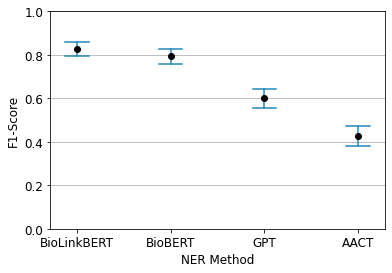

In [75]:
import matplotlib.pyplot as plt

model_names = ['BioLinkBERT', 'BioBERT', 'GPT', 'AACT']
biolinkbert = (0.793, 0.828, 0.858)
biobert = (0.757, 0.794, 0.827)
gpt = (0.554, 0.6, 0.645)
aact = (0.383, 0.428, 0.474)
plt.xticks([1, 2, 3, 4], model_names, fontsize=12)
#plt.title('Performance For CONDITION Recognition')
plot_confidence_interval(1, biolinkbert)
plot_confidence_interval(2, biobert)
plot_confidence_interval(3, gpt)
plot_confidence_interval(4, aact)
plt.grid(axis='y')  # Show only horizontal grid lines
plt.ylim(0, 1) #
plt.savefig('./evaluations/plots/abstract_level_majority_plot_with_CI_CONDITION.png')

In [76]:
for method in methods:
    for col_to_eval in col_names_to_eval:
        model = col_to_eval.split("_")[1]
        column_name = f"eval_{method}_{model}_tp_fp_fn"
        print(f"*** {column_name} ***")
        tp_sum = df_conditions_eval[column_name].apply(lambda x: x['tp']).sum()
        fp_sum = df_conditions_eval[column_name].apply(lambda x: x['fp']).sum()
        fn_sum = df_conditions_eval[column_name].apply(lambda x: x['fn']).sum()
        print("* F1 *")
        print(wilson_score_interval(tp_sum, fp_sum, fn_sum, "f1"))
        #print("* P *")
        #print(wilson_score_interval(tp_sum, fp_sum, fn_sum, "precision"))
        #print("* R *")
        #print(wilson_score_interval(tp_sum, fp_sum, fn_sum, "recall"))

*** eval_exact_match_BioLinkBERT-base_tp_fp_fn ***
* F1 *
(0.737, 0.775, 0.809)
*** eval_exact_match_biobert-v1.1_tp_fp_fn ***
* F1 *
(0.687, 0.727, 0.764)
*** eval_exact_match_gpt_tp_fp_fn ***
* F1 *
(0.442, 0.489, 0.537)
*** eval_exact_match_aact_tp_fp_fn ***
* F1 *
(0.3, 0.342, 0.387)
*** eval_majority_BioLinkBERT-base_tp_fp_fn ***
* F1 *
(0.793, 0.828, 0.858)
*** eval_majority_biobert-v1.1_tp_fp_fn ***
* F1 *
(0.757, 0.794, 0.827)
*** eval_majority_gpt_tp_fp_fn ***
* F1 *
(0.554, 0.6, 0.645)
*** eval_majority_aact_tp_fp_fn ***
* F1 *
(0.383, 0.428, 0.474)


In [77]:
df_conditions_eval.head(2)

,nct_id,canonical_unique_conditions,canonical_aact_conditions,canonical_BioLinkBERT-base_conditions,canonical_biobert-v1.1_conditions,canonical_gpt_conditions,eval_exact_match_BioLinkBERT-base,eval_exact_match_BioLinkBERT-base_tp_fp_fn,eval_exact_match_biobert-v1.1,eval_exact_match_biobert-v1.1_tp_fp_fn,...,eval_exact_match_aact,eval_exact_match_aact_tp_fp_fn,eval_majority_BioLinkBERT-base,eval_majority_BioLinkBERT-base_tp_fp_fn,eval_majority_biobert-v1.1,eval_majority_biobert-v1.1_tp_fp_fn,eval_majority_gpt,eval_majority_gpt_tp_fp_fn,eval_majority_aact,eval_majority_aact_tp_fp_fn
0,NCT04849741,axd.|alexander disease,alexander disease,axd|alexander disease,axd|alexander disease,alexander disease,"{'p': 0.5, 'r': 0.5, 'f1': 0.5}","{'tp': 1, 'fp': 1, 'fn': 1}","{'p': 0.5, 'r': 0.5, 'f1': 0.5}","{'tp': 1, 'fp': 1, 'fn': 1}",...,"{'p': 1.0, 'r': 0.5, 'f1': 0.67}","{'tp': 1, 'fp': 0, 'fn': 1}","{'p': 0.5, 'r': 0.5, 'f1': 0.5}","{'tp': 1, 'fp': 1, 'fn': 1}","{'p': 0.5, 'r': 0.5, 'f1': 0.5}","{'tp': 1, 'fp': 1, 'fn': 1}","{'p': 1.0, 'r': 0.5, 'f1': 0.67}","{'tp': 1, 'fp': 0, 'fn': 1}","{'p': 1.0, 'r': 0.5, 'f1': 0.67}","{'tp': 1, 'fp': 0, 'fn': 1}"
1,NCT04576507,pain|chronic pain,cannabis|hyperalgesia|pain|tolerance,hyperalgesia|pain|chronic pain,pain|chronic pain,chronic pain|abuse liability|hyperalgesia,"{'p': 0.67, 'r': 1.0, 'f1': 0.8}","{'tp': 2, 'fp': 1, 'fn': 0}","{'p': 1.0, 'r': 1.0, 'f1': 1.0}","{'tp': 2, 'fp': 0, 'fn': 0}",...,"{'p': 0.25, 'r': 0.5, 'f1': 0.33}","{'tp': 1, 'fp': 3, 'fn': 1}","{'p': 0.67, 'r': 1.0, 'f1': 0.8}","{'tp': 2, 'fp': 1, 'fn': 0}","{'p': 1.0, 'r': 1.0, 'f1': 1.0}","{'tp': 2, 'fp': 0, 'fn': 0}","{'p': 0.5, 'r': 1.0, 'f1': 0.67}","{'tp': 2, 'fp': 2, 'fn': 0}","{'p': 0.25, 'r': 0.5, 'f1': 0.33}","{'tp': 1, 'fp': 3, 'fn': 1}"


In [78]:
def calculate_mean_scores(df, eval_column_name, model_name, application="conditions"):
    # IGNORE TRUE NEGATIVES
    columns_to_check = [f'canonical_unique_{application}', f'canonical_{model_name}_{application}']
    df_without_tn = df.dropna(subset=columns_to_check, how='all')
    print("Evaluated rows: ", len(df_without_tn))
    
    mean_p = df_without_tn[eval_column_name].apply(lambda x: x['p']).mean()
    mean_r = df_without_tn[eval_column_name].apply(lambda x: x['r']).mean()
    mean_f1 = df_without_tn[eval_column_name].apply(lambda x: x['f1']).mean()
    print(f"Mean p {model_name}:", round(mean_p, 3))
    print(f"Mean r {model_name}:", round(mean_r, 3))
    print(f"Mean f1 {model_name}:", round(mean_f1, 3))

In [79]:
for method in methods:
    print()
    for col_to_eval in col_names_to_eval:
        model = col_to_eval.split("_")[1]
        column_name = f"eval_{method}_{model}"
        print(f"*** {column_name} ***")
        calculate_mean_scores(df_conditions_eval, column_name, model)


*** eval_exact_match_BioLinkBERT-base ***
Evaluated rows:  85
Mean p BioLinkBERT-base: 0.8
Mean r BioLinkBERT-base: 0.846
Mean f1 BioLinkBERT-base: 0.806
*** eval_exact_match_biobert-v1.1 ***
Evaluated rows:  85
Mean p biobert-v1.1: 0.781
Mean r biobert-v1.1: 0.793
Mean f1 biobert-v1.1: 0.766
*** eval_exact_match_gpt ***
Evaluated rows:  90
Mean p gpt: 0.746
Mean r gpt: 0.505
Mean f1 gpt: 0.56
*** eval_exact_match_aact ***
Evaluated rows:  90
Mean p aact: 0.531
Mean r aact: 0.352
Mean f1 aact: 0.389

*** eval_majority_BioLinkBERT-base ***
Evaluated rows:  85
Mean p BioLinkBERT-base: 0.846
Mean r BioLinkBERT-base: 0.887
Mean f1 BioLinkBERT-base: 0.851
*** eval_majority_biobert-v1.1 ***
Evaluated rows:  85
Mean p biobert-v1.1: 0.827
Mean r biobert-v1.1: 0.846
Mean f1 biobert-v1.1: 0.816
*** eval_majority_gpt ***
Evaluated rows:  90
Mean p gpt: 0.816
Mean r gpt: 0.609
Mean f1 gpt: 0.651
*** eval_majority_aact ***
Evaluated rows:  90
Mean p aact: 0.58
Mean r aact: 0.439
Mean f1 aact: 0.45

## Normalize and evaluate Drugs

In [80]:
import csv
import re

In [82]:
path_prefix = "../data"

In [83]:
variant_regex = re.compile(r'^[A-Za-z0-9,]+[ -]?[A-Za-z0-9\-]+(?:[ -][A-Z])?$')
drug_variant_to_canonical = {}
drug_canonical_to_data = {}

def add_variant(canonical_name, variant):
    if variant not in drug_variant_to_canonical:
        drug_variant_to_canonical[variant] = set()
    drug_variant_to_canonical[variant].add(canonical_name)


def add_drug(id, synonyms):
    synonyms = [s.strip() for s in synonyms]

    #TODO: add using an exclusion list as a parameter option to the function
    #if re.sub("[- ].+", "", synonyms[0].upper()) in exclusions:
    #    return
    if not variant_regex.match(synonyms[0]):
        return
    if synonyms[0] not in drug_canonical_to_data:
        drug_canonical_to_data[synonyms[0]] = {"name": synonyms[0], "synonyms": set()}
    if id.startswith("a"):
        drug_canonical_to_data[synonyms[0]]["medline_plus_id"] = id
    elif id.startswith("https://www.nhs.uk"):
        drug_canonical_to_data[synonyms[0]]["nhs_url"] = id
    elif id.startswith("https://en.wikipedia"):
        drug_canonical_to_data[synonyms[0]]["wikipedia_url"] = id
    elif id.startswith("DB"):
        drug_canonical_to_data[synonyms[0]]["drugbank_id"] = id
    else:
        drug_canonical_to_data[synonyms[0]]["mesh_id"] = id
    for variant in synonyms:
        #if re.sub(" .+", "", variant.upper()) in exclusions:
        #    return
        if variant_regex.match(variant):
            drug_canonical_to_data[synonyms[0]]["synonyms"].add(variant)
            add_variant(synonyms[0], variant.lower())
            #add_variant(synonyms[0], variant)
            #add_variant(synonyms[0], variant.upper())
            #if variant.lower() in words_to_allow_lower_case:    

with open(path_prefix + "/drug_names_terminology/drugs_dictionary_medlineplus.csv", 'r', encoding="utf-8") as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',')
    headers = None
    for row in spamreader:
        if not headers:
            headers = row
            continue
        id = row[0]
        name = row[1]
        synonyms = row[2].split(r"|")
        name = re.sub(
            " (Injection|Oral Inhalation|Transdermal|Ophthalmic|Topical|Vaginal Cream|Nasal Spray|Transdermal Patch|Rectal)",
            "", name)
        name = name.lower()
        if name == "abobotulinumtoxina":
            print(row[1], synonyms)

        add_drug(id, [name] + synonyms)

AbobotulinumtoxinA Injection ['Dysport', 'BoNT-A']


In [84]:

with open(path_prefix + "/drug_names_terminology/drugs_dictionary_nhs.csv", 'r', encoding="utf-8") as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',')
    headers = None
    for row in spamreader:
        if not headers:
            headers = row
            continue
        id = row[0]
        name = row[1]
        synonyms = row[2].split(r"|")
        name = name.lower()
        add_drug(id, [name] + synonyms)


with open(path_prefix + "/drug_names_terminology/drugs_dictionary_wikipedia.csv", 'r', encoding="utf-8") as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',')
    headers = None
    for row in spamreader:
        if not headers:
            headers = row
            continue
        id = row[0]
        name = row[1]
        synonyms = row[2].split(r"|")
        name = name.lower()
        add_drug(id, [name] + synonyms)
        
with open(path_prefix + "/drug_names_terminology/drugs_dictionary_mesh.csv", 'r', encoding="utf-8") as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',')
    headers = None
    for row in spamreader:
        if not headers:
            headers = row
            continue
        id = row[0]
        name = row[1]
        synonyms = row[2].split(r"\|")
        name = name.lower()
        add_drug(id, [name] + synonyms)

# adding for the full db with product names included as synonyms
# TODO: create a parametrized function from this, not hard-coded inline as it is
is_new_format = False
if is_new_format:
    with open(path_prefix + "/drug_names_terminology/drugdb_full_database_parsed.csv", 'r', encoding="utf-8") as csvfile:
        spamreader = csv.reader(csvfile, delimiter=';')
        headers = None
        for row in spamreader:
            #print(row)
            if not headers:
                headers = row
                continue
            id = row[0]
            name = row[1]
            synonyms = row[4].split(r"|")
            products = row[5].split(r"|")
            syn_prod = synonyms + products
            name = name.lower()
            add_drug(id, [name] + syn_prod)
# no product names considered
else:
    with open(path_prefix + "/drug_names_terminology/drugbank vocabulary.csv", 'r', encoding="utf-8") as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',')
        headers = None
        for row in spamreader:
            if not headers:
                headers = row
                continue
            id = row[0]
            name = row[2]
            synonyms = row[5].split(r"|")
            name = name.lower()
            add_drug(id, [name] + synonyms)

In [85]:
drug_variant_to_canonical.get("exelon")

{'rivastigmine', 'rivastigmine patch'}

In [86]:
df_unique_labels.head(-5)

,nct_id,unique_conditions_target,unique_interventions_target,unique_interventions_type_target,unique_conditions_BioLinkBERT-base_predictions,unique_interventions_BioLinkBERT-base_predictions,unique_interventions_type_BioLinkBERT-base_predictions,unique_conditions_biobert-v1.1_predictions,unique_interventions_biobert-v1.1_predictions,unique_interventions_type_biobert-v1.1_predictions,aact_conditions,aact_intervention_types,aact_intervention_names,Unnamed: 0,text,gpt_predictions_conditions,gpt_predictions_interventions
0,NCT04849741,axd.|alexander disease,ion373,DRUG,axd|alexander disease,ion373,DRUG,axd|alexander disease,ion373,DRUG,Alexander Disease,Drug,ION373|,0,"A Phase 1-3, Double-Blind, Randomized, Placebo...",Alexander Disease,ION373
1,NCT04576507,pain|chronic pain,cannabidiol|cannabinoid|delta-9-tetrahydrocann...,DRUG,hyperalgesia|pain|chronic pain,cannabidiol|cannabinoids|cannabidi,DRUG,pain|chronic pain,canna|cannabidiol|cannabino,DRUG,Cannabis|Hyperalgesia|Pain|Tolerance,Drug,Cannabis,1,Effects of Repeated Cannabis Administration on...,chronic pain|abuse liability|hyperalgesia,cannabis|opioids|cannabinoids|delta-9-tetrahyd...
2,NCT00261508,autistic disorder|pervasive developmental diso...,risperidone|antipsychotic medication,DRUG,autistic disorder|pervasive developmental diso...,risperidone|antipsychotic medication,DRUG,autistic disorder|pervasive developmental diso...,antipsy,DRUG,Asperger Syndrome|Autistic Disorder|DCild Deve...,Drug,risperidone,2,Efficacy And Safety Of Risperidone In The Trea...,Autistic Disorder|Pervasive Developmental Diso...,risperidone|placebo
3,NCT01495923,lumbosacral radiculopathy|lumbosacral radicula...,gabapentin|steroid,DRUG,pain|lumbosacral radiculopathy|lumbosacral rad...,gabapentin,DRUG,pain|lumbosacral radiculopathy|lumbosacral rad...,gabapentin,DRUG,Radiculopathy|Sciatica,Drug|Procedure,Gabapentin| gabapentin|Sham epidural steroid i...,3,"Randomized, Double-blind, Comparative-effectiv...",Lumbosacral radiculopathy,Epidural Steroid Injections | Gabapentin
4,NCT03150563,,,,,,,,,,"Contracture of Muscle, Thigh|Muscle Rigidity|S...",Other,,4,Effects of Different Intensities of Passive St...,flexibility|neuromuscular performance|function...,none
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,NCT00909012,phenylketonuria,docosahexaenoic acid,DRUG,phenylketonuria,docosahexaenoic acid|fish oil,DRUG,phenylketonuria|classical pku,docosahexaenoic acid,DRUG,Phenylketonuria,Dietary Supplement,,80,Quantitative Requirements of Docosahexaenoic A...,Phenylketonuria|PKU,Docosahexaenoic Acid (DHA) | fish oil
81,NCT04955249,hip fracture surgery|delirium,dexmedetomidine,DRUG,hip fracture surgery|delirium,dexmedetomidine,DRUG,hip fracture surgery|delirium,dexmedetomidine,DRUG,Dexmedetomidine|Elderly|Hip Fracture Surgery|P...,Drug,Dexmedetomidine|,81,Impact of Dexmedetomidine Supplemented Analges...,Delirium|hip fracture surgery,Dexmedetomidine
82,NCT00252850,idiopathic parkinson's disease,,,idiopathic parkinson's disease,neurturin|ntn|cere-120,DRUG,idiopathic parkinson's disease,neurturin|ntn|cere-120|adeno-associated virus ...,DRUG,Parkinson's Disease,Genetic,,82,"A Phase I, Open-Label Study of CERE-120 (Adeno...",Parkinson's Disease,CERE-120|Adeno-Associated Virus Serotype 2 [AA...
83,NCT02840643,hemiplegia|unilateral brain injury,,,hemiplegia|unilateral brain injury,,,unilateral brain injury,,,Cerebral Palsy|Hemiplegia,Behavioral,,83,Combined Constraint Therapy and Bimanual Thera...,Unilateral Brain Injury | hemiplegia therapy,Combined Constraint Therapy and Bimanual Thera...


In [87]:
df_interventions = df_unique_labels[["nct_id", "unique_interventions_target", f'unique_interventions_{model_name_str_biolink}_predictions', 
                                     f'unique_interventions_{model_name_str_biobert}_predictions', 'aact_intervention_names', 'gpt_predictions_interventions']]


In [88]:
df_interventions.head(-5)

,nct_id,unique_interventions_target,unique_interventions_BioLinkBERT-base_predictions,unique_interventions_biobert-v1.1_predictions,aact_intervention_names,gpt_predictions_interventions
0,NCT04849741,ion373,ion373,ion373,ION373|,ION373
1,NCT04576507,cannabidiol|cannabinoid|delta-9-tetrahydrocann...,cannabidiol|cannabinoids|cannabidi,canna|cannabidiol|cannabino,Cannabis,cannabis|opioids|cannabinoids|delta-9-tetrahyd...
2,NCT00261508,risperidone|antipsychotic medication,risperidone|antipsychotic medication,antipsy,risperidone,risperidone|placebo
3,NCT01495923,gabapentin|steroid,gabapentin,gabapentin,Gabapentin| gabapentin|Sham epidural steroid i...,Epidural Steroid Injections | Gabapentin
4,NCT03150563,,,,,none
...,...,...,...,...,...,...
80,NCT00909012,docosahexaenoic acid,docosahexaenoic acid|fish oil,docosahexaenoic acid,,Docosahexaenoic Acid (DHA) | fish oil
81,NCT04955249,dexmedetomidine,dexmedetomidine,dexmedetomidine,Dexmedetomidine|,Dexmedetomidine
82,NCT00252850,,neurturin|ntn|cere-120,neurturin|ntn|cere-120|adeno-associated virus ...,,CERE-120|Adeno-Associated Virus Serotype 2 [AA...
83,NCT02840643,,,,,Combined Constraint Therapy and Bimanual Thera...


In [89]:
def process_dataframe_interventions(df, synonyms_dict):
    df.loc[:, 'canonical_unique_interventions'] = df['unique_interventions_target'].apply(lookup_canonical, synonyms_dict=synonyms_dict)
    df.loc[:, f'canonical_{model_name_str_biolink}_interventions'] = df[f'unique_interventions_{model_name_str_biolink}_predictions'].apply(lookup_canonical, synonyms_dict=synonyms_dict)
    df.loc[:, f'canonical_{model_name_str_biobert}_interventions'] = df[f'unique_interventions_{model_name_str_biobert}_predictions'].apply(lookup_canonical, synonyms_dict=synonyms_dict)
    df.loc[:, 'canonical_aact_interventions'] = df['aact_intervention_names'].apply(lookup_canonical, synonyms_dict=synonyms_dict)
    df.loc[:, 'canonical_gpt_interventions'] = df['gpt_predictions_interventions'].apply(lookup_canonical, synonyms_dict=synonyms_dict)
    return df

In [90]:
df_interventions_mapped = process_dataframe_interventions(df_interventions, drug_variant_to_canonical)

/Users/donevas/opt/miniconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [91]:
df_interventions_mapped

,nct_id,unique_interventions_target,unique_interventions_BioLinkBERT-base_predictions,unique_interventions_biobert-v1.1_predictions,aact_intervention_names,gpt_predictions_interventions,canonical_unique_interventions,canonical_BioLinkBERT-base_interventions,canonical_biobert-v1.1_interventions,canonical_aact_interventions,canonical_gpt_interventions
0,NCT04849741,ion373,ion373,ion373,ION373|,ION373,ion373,ion373,ion373,ion373,ion373
1,NCT04576507,cannabidiol|cannabinoid|delta-9-tetrahydrocann...,cannabidiol|cannabinoids|cannabidi,canna|cannabidiol|cannabino,Cannabis,cannabis|opioids|cannabinoids|delta-9-tetrahyd...,cannabidiol|cannabinoid|dronabinol|cannabinoid...,cannabidiol|cannabinoids|cannabidi,canna|cannabidiol|cannabino,medical cannabis,medical cannabis|opioids|cannabinoids|dronabin...
2,NCT00261508,risperidone|antipsychotic medication,risperidone|antipsychotic medication,antipsy,risperidone,risperidone|placebo,risperidone|antipsychotic medication,risperidone|antipsychotic medication,antipsy,risperidone,risperidone|placebo
3,NCT01495923,gabapentin|steroid,gabapentin,gabapentin,Gabapentin| gabapentin|Sham epidural steroid i...,Epidural Steroid Injections | Gabapentin,gabapentin|steroid,gabapentin,gabapentin,gabapentin|gabapentin|sham epidural steroid in...,epidural steroid injections|gabapentin
4,NCT03150563,,,,,none,,,,,
...,...,...,...,...,...,...,...,...,...,...,...
85,NCT03755362,,,,,none.,,,,,
86,NCT00506415,rivastigmine|exelon,rivastigmine|exelon,rivastigmine|exelo,to 10 cm^2 patch| to 15 cm^2 patch|Rivastigmi...,Exelon®|rivastigmine,rivastigmine|rivastigmine|rivastigmine patch,rivastigmine|rivastigmine|rivastigmine patch,rivastigmine|exelo,to 10 cm^2 patch|to 15 cm^2 patch|rivastigmine...,exelon®|rivastigmine
87,NCT01344447,,gadobutrol,gadobutrol,"Gadobutrol (Gadovist, BAY86-4875)",Gadobutrol|none,,gadobutrol,gadobutrol,"gadobutrol (gadovist, bay86-4875)",gadobutrol
88,NCT04184206,,,,,none,,,,,


In [92]:
df_interventions_eval = df_interventions_mapped[['nct_id', 'canonical_unique_interventions', f'canonical_{model_name_str_biolink}_interventions', f'canonical_{model_name_str_biobert}_interventions', 'canonical_gpt_interventions', 'canonical_aact_interventions']]

In [93]:
methods = ["exact_match", "majority"] #, "majority", "levenshtein", "at_least_one", "at_least_one_overall"
col_names_to_eval = [f'canonical_{model_name_str_biolink}_interventions', f'canonical_{model_name_str_biobert}_interventions', 'canonical_gpt_interventions', 'canonical_aact_interventions']

for method in methods:
    for col_to_eval in col_names_to_eval:
        model = col_to_eval.split("_")[1]
        print(f"*** Eval {model} ***")
        column_name = f"eval_{method}_{model}"
        column_name_basic_metrics = f"eval_{method}_{model}_tp_fp_fn"
        df_interventions_eval[column_name] =  df_interventions_eval.apply(lambda row: calculate_precision_recall_v2(row[col_to_eval].split("|"), row["canonical_unique_interventions"].split("|"), method=method, threshold=0.5), axis=1)
        df_interventions_eval[column_name_basic_metrics] =  df_interventions_eval.apply(lambda row: calculate_tp_fp_fn(row[col_to_eval].split("|"), row["canonical_unique_interventions"].split("|"), method=method, threshold=0.5), axis=1)  

*** Eval BioLinkBERT-base ***
*** Eval biobert-v1.1 ***
*** Eval gpt ***
*** Eval aact ***
*** Eval BioLinkBERT-base ***
*** Eval biobert-v1.1 ***
*** Eval gpt ***
*** Eval aact ***


/var/folders/px/wtj901jn7z9f26xgbys4l7jh0000gp/T/ipykernel_64237/4051678439.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_interventions_eval[column_name] =  df_interventions_eval.apply(lambda row: calculate_precision_recall_v2(row[col_to_eval].split("|"), row["canonical_unique_interventions"].split("|"), method=method, threshold=0.5), axis=1)
/var/folders/px/wtj901jn7z9f26xgbys4l7jh0000gp/T/ipykernel_64237/4051678439.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_interventions_eval[column

In [94]:
df_interventions_eval.head(-5)

,nct_id,canonical_unique_interventions,canonical_BioLinkBERT-base_interventions,canonical_biobert-v1.1_interventions,canonical_gpt_interventions,canonical_aact_interventions,eval_exact_match_BioLinkBERT-base,eval_exact_match_BioLinkBERT-base_tp_fp_fn,eval_exact_match_biobert-v1.1,eval_exact_match_biobert-v1.1_tp_fp_fn,...,eval_exact_match_aact,eval_exact_match_aact_tp_fp_fn,eval_majority_BioLinkBERT-base,eval_majority_BioLinkBERT-base_tp_fp_fn,eval_majority_biobert-v1.1,eval_majority_biobert-v1.1_tp_fp_fn,eval_majority_gpt,eval_majority_gpt_tp_fp_fn,eval_majority_aact,eval_majority_aact_tp_fp_fn
0,NCT04849741,ion373,ion373,ion373,ion373,ion373,"{'p': 1.0, 'r': 1.0, 'f1': 1.0}","{'tp': 1, 'fp': 0, 'fn': 0}","{'p': 1.0, 'r': 1.0, 'f1': 1.0}","{'tp': 1, 'fp': 0, 'fn': 0}",...,"{'p': 1.0, 'r': 1.0, 'f1': 1.0}","{'tp': 1, 'fp': 0, 'fn': 0}","{'p': 1.0, 'r': 1.0, 'f1': 1.0}","{'tp': 1, 'fp': 0, 'fn': 0}","{'p': 1.0, 'r': 1.0, 'f1': 1.0}","{'tp': 1, 'fp': 0, 'fn': 0}","{'p': 1.0, 'r': 1.0, 'f1': 1.0}","{'tp': 1, 'fp': 0, 'fn': 0}","{'p': 1.0, 'r': 1.0, 'f1': 1.0}","{'tp': 1, 'fp': 0, 'fn': 0}"
1,NCT04576507,cannabidiol|cannabinoid|dronabinol|cannabinoid...,cannabidiol|cannabinoids|cannabidi,canna|cannabidiol|cannabino,medical cannabis|opioids|cannabinoids|dronabin...,medical cannabis,"{'p': 0.67, 'r': 0.5, 'f1': 0.57}","{'tp': 2, 'fp': 1, 'fn': 2}","{'p': 0.33, 'r': 0.25, 'f1': 0.29}","{'tp': 1, 'fp': 2, 'fn': 3}",...,"{'p': 0.0, 'r': 0.0, 'f1': 0}","{'tp': 0, 'fp': 1, 'fn': 4}","{'p': 0.67, 'r': 0.5, 'f1': 0.57}","{'tp': 2, 'fp': 1, 'fn': 2}","{'p': 0.33, 'r': 0.25, 'f1': 0.29}","{'tp': 1, 'fp': 2, 'fn': 3}","{'p': 0.6, 'r': 0.75, 'f1': 0.67}","{'tp': 3, 'fp': 2, 'fn': 1}","{'p': 0.0, 'r': 0.0, 'f1': 0}","{'tp': 0, 'fp': 1, 'fn': 4}"
2,NCT00261508,risperidone|antipsychotic medication,risperidone|antipsychotic medication,antipsy,risperidone|placebo,risperidone,"{'p': 1.0, 'r': 1.0, 'f1': 1.0}","{'tp': 2, 'fp': 0, 'fn': 0}","{'p': 0.0, 'r': 0.0, 'f1': 0}","{'tp': 0, 'fp': 1, 'fn': 2}",...,"{'p': 1.0, 'r': 0.5, 'f1': 0.67}","{'tp': 1, 'fp': 0, 'fn': 1}","{'p': 1.0, 'r': 1.0, 'f1': 1.0}","{'tp': 2, 'fp': 0, 'fn': 0}","{'p': 0.0, 'r': 0.0, 'f1': 0}","{'tp': 0, 'fp': 1, 'fn': 2}","{'p': 0.5, 'r': 0.5, 'f1': 0.5}","{'tp': 1, 'fp': 1, 'fn': 1}","{'p': 1.0, 'r': 0.5, 'f1': 0.67}","{'tp': 1, 'fp': 0, 'fn': 1}"
3,NCT01495923,gabapentin|steroid,gabapentin,gabapentin,epidural steroid injections|gabapentin,gabapentin|gabapentin|sham epidural steroid in...,"{'p': 1.0, 'r': 0.5, 'f1': 0.67}","{'tp': 1, 'fp': 0, 'fn': 1}","{'p': 1.0, 'r': 0.5, 'f1': 0.67}","{'tp': 1, 'fp': 0, 'fn': 1}",...,"{'p': 0.33, 'r': 0.5, 'f1': 0.4}","{'tp': 1, 'fp': 2, 'fn': 1}","{'p': 1.0, 'r': 0.5, 'f1': 0.67}","{'tp': 1, 'fp': 0, 'fn': 1}","{'p': 1.0, 'r': 0.5, 'f1': 0.67}","{'tp': 1, 'fp': 0, 'fn': 1}","{'p': 1.0, 'r': 1.0, 'f1': 1.0}","{'tp': 2, 'fp': 0, 'fn': 0}","{'p': 1.0, 'r': 1.0, 'f1': 1.0}","{'tp': 2, 'fp': 0, 'fn': 0}"
4,NCT03150563,,,,,,"{'p': 0, 'r': 0, 'f1': 0}","{'tp': 0, 'fp': 0, 'fn': 0}","{'p': 0, 'r': 0, 'f1': 0}","{'tp': 0, 'fp': 0, 'fn': 0}",...,"{'p': 0, 'r': 0, 'f1': 0}","{'tp': 0, 'fp': 0, 'fn': 0}","{'p': 0, 'r': 0, 'f1': 0}","{'tp': 0, 'fp': 0, 'fn': 0}","{'p': 0, 'r': 0, 'f1': 0}","{'tp': 0, 'fp': 0, 'fn': 0}","{'p': 0, 'r': 0, 'f1': 0}","{'tp': 0, 'fp': 0, 'fn': 0}","{'p': 0, 'r': 0, 'f1': 0}","{'tp': 0, 'fp': 0, 'fn': 0}"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,NCT00909012,doconexent,doconexent|fish oil,doconexent,docosahexaenoic acid (dha)|fish oil,,"{'p': 0.5, 'r': 1.0, 'f1': 0.67}","{'tp': 1, 'fp': 1, 'fn': 0}","{'p': 1.0, 'r': 1.0, 'f1': 1.0}","{'tp': 1, 'fp': 0, 'fn': 0}",...,"{'p': 0.0, 'r': 0.0, 'f1': 0}","{'tp': 0, 'fp': 1, 'fn': 1}","{'p': 0.5, 'r': 1.0, 'f1': 0.67}","{'tp': 1, 'fp': 1, 'fn': 0}","{'p': 1.0, 'r': 1.0, 'f1': 1.0}","{'tp': 1, 'fp': 0, 'fn': 0}","{'p': 0.0, 'r': 0.0, 'f1': 0}","{'tp': 0, 'fp': 2, 'fn': 1}","{'p': 0.0, 'r': 0.0, 'f1': 0}","{'tp': 0, 'fp': 1, 'fn': 1}"
81,N

In [95]:
import numpy as np
# Replace empty strings with NaN in column 'A'
df_interventions_eval['canonical_unique_interventions'] = df_interventions_eval['canonical_unique_interventions'].replace('', np.nan)
df_interventions_eval['canonical_BioLinkBERT-base_interventions'] = df_interventions_eval['canonical_BioLinkBERT-base_interventions'].replace('', np.nan)
df_interventions_eval['canonical_biobert-v1.1_interventions'] = df_interventions_eval['canonical_biobert-v1.1_interventions'].replace('', np.nan)
df_interventions_eval['canonical_gpt_interventions'] = df_interventions_eval['canonical_gpt_interventions'].replace('', np.nan)
df_interventions_eval['canonical_aact_interventions'] = df_interventions_eval['canonical_aact_interventions'].replace('', np.nan)

# IGNORE TRUE NEGATIVES
#columns_to_check = ['canonical_unique_interventions', 'canonical_BioLinkBERT-base_interventions', 'canonical_biobert-v1.1_interventions', 'canonical_gpt_interventions', 'canonical_aact_interventions']
#df_interventions_eval.dropna(subset=columns_to_check, how='all', inplace=True)

In [96]:
df_interventions_eval

,nct_id,canonical_unique_interventions,canonical_BioLinkBERT-base_interventions,canonical_biobert-v1.1_interventions,canonical_gpt_interventions,canonical_aact_interventions,eval_exact_match_BioLinkBERT-base,eval_exact_match_BioLinkBERT-base_tp_fp_fn,eval_exact_match_biobert-v1.1,eval_exact_match_biobert-v1.1_tp_fp_fn,...,eval_exact_match_aact,eval_exact_match_aact_tp_fp_fn,eval_majority_BioLinkBERT-base,eval_majority_BioLinkBERT-base_tp_fp_fn,eval_majority_biobert-v1.1,eval_majority_biobert-v1.1_tp_fp_fn,eval_majority_gpt,eval_majority_gpt_tp_fp_fn,eval_majority_aact,eval_majority_aact_tp_fp_fn
0,NCT04849741,ion373,ion373,ion373,ion373,ion373,"{'p': 1.0, 'r': 1.0, 'f1': 1.0}","{'tp': 1, 'fp': 0, 'fn': 0}","{'p': 1.0, 'r': 1.0, 'f1': 1.0}","{'tp': 1, 'fp': 0, 'fn': 0}",...,"{'p': 1.0, 'r': 1.0, 'f1': 1.0}","{'tp': 1, 'fp': 0, 'fn': 0}","{'p': 1.0, 'r': 1.0, 'f1': 1.0}","{'tp': 1, 'fp': 0, 'fn': 0}","{'p': 1.0, 'r': 1.0, 'f1': 1.0}","{'tp': 1, 'fp': 0, 'fn': 0}","{'p': 1.0, 'r': 1.0, 'f1': 1.0}","{'tp': 1, 'fp': 0, 'fn': 0}","{'p': 1.0, 'r': 1.0, 'f1': 1.0}","{'tp': 1, 'fp': 0, 'fn': 0}"
1,NCT04576507,cannabidiol|cannabinoid|dronabinol|cannabinoid...,cannabidiol|cannabinoids|cannabidi,canna|cannabidiol|cannabino,medical cannabis|opioids|cannabinoids|dronabin...,medical cannabis,"{'p': 0.67, 'r': 0.5, 'f1': 0.57}","{'tp': 2, 'fp': 1, 'fn': 2}","{'p': 0.33, 'r': 0.25, 'f1': 0.29}","{'tp': 1, 'fp': 2, 'fn': 3}",...,"{'p': 0.0, 'r': 0.0, 'f1': 0}","{'tp': 0, 'fp': 1, 'fn': 4}","{'p': 0.67, 'r': 0.5, 'f1': 0.57}","{'tp': 2, 'fp': 1, 'fn': 2}","{'p': 0.33, 'r': 0.25, 'f1': 0.29}","{'tp': 1, 'fp': 2, 'fn': 3}","{'p': 0.6, 'r': 0.75, 'f1': 0.67}","{'tp': 3, 'fp': 2, 'fn': 1}","{'p': 0.0, 'r': 0.0, 'f1': 0}","{'tp': 0, 'fp': 1, 'fn': 4}"
2,NCT00261508,risperidone|antipsychotic medication,risperidone|antipsychotic medication,antipsy,risperidone|placebo,risperidone,"{'p': 1.0, 'r': 1.0, 'f1': 1.0}","{'tp': 2, 'fp': 0, 'fn': 0}","{'p': 0.0, 'r': 0.0, 'f1': 0}","{'tp': 0, 'fp': 1, 'fn': 2}",...,"{'p': 1.0, 'r': 0.5, 'f1': 0.67}","{'tp': 1, 'fp': 0, 'fn': 1}","{'p': 1.0, 'r': 1.0, 'f1': 1.0}","{'tp': 2, 'fp': 0, 'fn': 0}","{'p': 0.0, 'r': 0.0, 'f1': 0}","{'tp': 0, 'fp': 1, 'fn': 2}","{'p': 0.5, 'r': 0.5, 'f1': 0.5}","{'tp': 1, 'fp': 1, 'fn': 1}","{'p': 1.0, 'r': 0.5, 'f1': 0.67}","{'tp': 1, 'fp': 0, 'fn': 1}"
3,NCT01495923,gabapentin|steroid,gabapentin,gabapentin,epidural steroid injections|gabapentin,gabapentin|gabapentin|sham epidural steroid in...,"{'p': 1.0, 'r': 0.5, 'f1': 0.67}","{'tp': 1, 'fp': 0, 'fn': 1}","{'p': 1.0, 'r': 0.5, 'f1': 0.67}","{'tp': 1, 'fp': 0, 'fn': 1}",...,"{'p': 0.33, 'r': 0.5, 'f1': 0.4}","{'tp': 1, 'fp': 2, 'fn': 1}","{'p': 1.0, 'r': 0.5, 'f1': 0.67}","{'tp': 1, 'fp': 0, 'fn': 1}","{'p': 1.0, 'r': 0.5, 'f1': 0.67}","{'tp': 1, 'fp': 0, 'fn': 1}","{'p': 1.0, 'r': 1.0, 'f1': 1.0}","{'tp': 2, 'fp': 0, 'fn': 0}","{'p': 1.0, 'r': 1.0, 'f1': 1.0}","{'tp': 2, 'fp': 0, 'fn': 0}"
4,NCT03150563,NaN,NaN,NaN,NaN,NaN,"{'p': 0, 'r': 0, 'f1': 0}","{'tp': 0, 'fp': 0, 'fn': 0}","{'p': 0, 'r': 0, 'f1': 0}","{'tp': 0, 'fp': 0, 'fn': 0}",...,"{'p': 0, 'r': 0, 'f1': 0}","{'tp': 0, 'fp': 0, 'fn': 0}","{'p': 0, 'r': 0, 'f1': 0}","{'tp': 0, 'fp': 0, 'fn': 0}","{'p': 0, 'r': 0, 'f1': 0}","{'tp': 0, 'fp': 0, 'fn': 0}","{'p': 0, 'r': 0, 'f1': 0}","{'tp': 0, 'fp': 0, 'fn': 0}","{'p': 0, 'r': 0, 'f1': 0}","{'tp': 0, 'fp': 0, 'fn': 0}"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,NCT03755362,NaN,NaN,NaN,NaN,NaN,"{'p': 0, 'r': 0, 'f1': 0}","{'tp': 0, 'fp': 0, 'fn': 0}","{'p': 0, 'r': 0, 'f1': 0}","{'tp': 0, 'fp': 0, 'fn': 0}",...,"{'p': 0, 'r': 0, 'f1': 0}","{'tp': 0, 'fp': 0, 'fn': 0}","{'p': 0, 'r': 0, 'f1': 0}","{'tp': 0, 'fp': 0, 'fn': 0}","{'p': 0, 'r': 0, 'f1': 0}","{'tp': 0, 'fp': 0, 'fn': 0}","{'p': 0, 'r': 0, 'f1': 0}","{'tp': 0, 'fp': 0, 'fn': 0}","{'p': 0, 'r': 0, 'f1': 0}","{'tp': 0, 'fp': 0, 'fn': 0}"
86,NCT00506415,rivastigmine|rivastigmine|rivastigmine patch,rivastigmine|rivastigmine|

In [97]:
nan_counts = df_interventions_eval['canonical_unique_interventions'].isna().sum()

# Display the NaN counts for each column
print(nan_counts, 90-nan_counts)

58 32


In [99]:
df_interventions_eval.to_csv("./evaluations/evaluated_ct_level_drugs.csv")


In [100]:
for method in methods:
    for col_to_eval in col_names_to_eval:
        model = col_to_eval.split("_")[1]
        column_name = f"eval_{method}_{model}_tp_fp_fn"
        print(f"*** {column_name} ***")
        tp_sum = df_interventions_eval[column_name].apply(lambda x: x['tp']).sum()
        fp_sum = df_interventions_eval[column_name].apply(lambda x: x['fp']).sum()
        fn_sum = df_interventions_eval[column_name].apply(lambda x: x['fn']).sum()
        print("* F1 *")
        print(wilson_score_interval(tp_sum, fp_sum, fn_sum, "f1"))
        #print("* P *")
        #print(wilson_score_interval(tp_sum, fp_sum, fn_sum, "precision"))
        #print("* R *")
        #print(wilson_score_interval(tp_sum, fp_sum, fn_sum, "recall"))

*** eval_exact_match_BioLinkBERT-base_tp_fp_fn ***
* F1 *
(0.682, 0.761, 0.825)
*** eval_exact_match_biobert-v1.1_tp_fp_fn ***
* F1 *
(0.546, 0.629, 0.704)
*** eval_exact_match_gpt_tp_fp_fn ***
* F1 *
(0.241, 0.292, 0.349)
*** eval_exact_match_aact_tp_fp_fn ***
* F1 *
(0.315, 0.392, 0.473)
*** eval_majority_BioLinkBERT-base_tp_fp_fn ***
* F1 *
(0.698, 0.776, 0.838)
*** eval_majority_biobert-v1.1_tp_fp_fn ***
* F1 *
(0.571, 0.652, 0.726)
*** eval_majority_gpt_tp_fp_fn ***
* F1 *
(0.29, 0.345, 0.403)
*** eval_majority_aact_tp_fp_fn ***
* F1 *
(0.411, 0.493, 0.575)


In [101]:
import matplotlib.pyplot as plt


In [102]:
def plot_confidence_interval(x, values, z=1.96, color='#2187bb', horizontal_line_width=0.25):
    mean = values[1]
    top = values[2]
    bottom = values[0]

    left = x - horizontal_line_width / 2
    right = x + horizontal_line_width / 2
    
    plt.plot([x, x], [top, bottom], color=color)
    plt.plot([left, right], [top, top], color=color)
    plt.plot([left, right], [bottom, bottom], color=color)
    plt.plot(x, mean, 'o', color='black')
    plt.xlabel('NER Method', fontsize=12)  # Add x-axis label
    plt.ylabel('F1-Score', fontsize=12)    # Add y-axis label
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

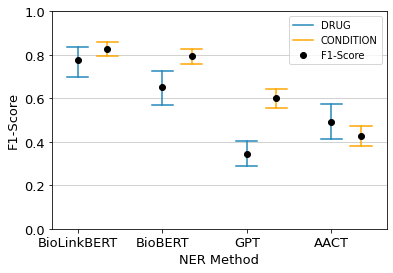

In [103]:
import matplotlib.pyplot as plt

def plot_confidence_intervals(x, values1, values2, labels, legend=False, z=1.96, horizontal_line_width=0.25):
    mean1 = values1[1]
    top1 = values1[2]
    bottom1 = values1[0]

    mean2 = values2[1]
    top2 = values2[2]
    bottom2 = values2[0]

    left = x - horizontal_line_width / 2
    right = x + horizontal_line_width / 2
    
    if legend:
        plt.plot([x, x], [top1, bottom1], color=labels[0], label='DRUG')
        plt.plot([x + 0.35, x + 0.35], [top2, bottom2], color=labels[1], label='CONDITION')
    else:
        plt.plot([x, x], [top1, bottom1], color=labels[0])
        plt.plot([x + 0.35, x + 0.35], [top2, bottom2], color=labels[1])
    plt.plot([left, right], [top1, top1], color=labels[0])
    plt.plot([left, right], [bottom1, bottom1], color=labels[0])
    plt.plot([left + 0.35, right + 0.35], [top2, top2], color=labels[1])
    plt.plot([left + 0.35, right + 0.35], [bottom2, bottom2], color=labels[1])
    if legend:
        plt.plot(x, mean1, 'o', color='black', label='F1-Score')
    else:
        plt.plot(x, mean1, 'o', color='black')
    plt.plot(x + 0.35, mean2, 'o', color='black')
    plt.xlabel('NER Method', fontsize=13)  # Add x-axis label
    plt.ylabel('F1-Score', fontsize=13)    # Add y-axis label
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)

model_names = ['BioLinkBERT', 'BioBERT', 'GPT', 'AACT']

# DRUG SCORES
biolinkbert_drug = (0.698, 0.776, 0.838)
biobert_drug = (0.571, 0.652, 0.726)
gpt_drug = (0.29, 0.345, 0.403)
aact_drug = (0.411, 0.493, 0.575)

# CONDITION SCORES
biolinkbert_condition = (0.793, 0.828, 0.858)
biobert_condition = (0.757, 0.794, 0.827)
gpt_condition = (0.554, 0.6, 0.645)
aact_condition = (0.383, 0.428, 0.474)

plt.xticks([1, 2, 3, 4], model_names, fontsize=12)
#plt.title('DRUG and CONDITION Recognition Performance')

plot_confidence_intervals(1, biolinkbert_drug, biolinkbert_condition, ['#2187bb', 'orange'], legend=True)
plot_confidence_intervals(2, biobert_drug, biobert_condition, ['#2187bb', 'orange'])
plot_confidence_intervals(3, gpt_drug, gpt_condition, ['#2187bb', 'orange'])
plot_confidence_intervals(4, aact_drug, aact_condition, ['#2187bb', 'orange'])

plt.grid(axis='y', alpha=0.7)  # Show only horizontal grid lines
plt.ylim(0, 1)
plt.legend()
plt.savefig('./evaluations/plots/abstract_level_majority_plot_with_CI_DRUG_CONDITION.png')
plt.show()


In [104]:
for method in methods:
    print()
    for col_to_eval in col_names_to_eval:
        model = col_to_eval.split("_")[1]
        column_name = f"eval_{method}_{model}"
        print(f"*** {column_name} ***")
        calculate_mean_scores(df_interventions_eval, column_name, model, "interventions")


*** eval_exact_match_BioLinkBERT-base ***
Evaluated rows:  35
Mean p BioLinkBERT-base: 0.772
Mean r BioLinkBERT-base: 0.813
Mean f1 BioLinkBERT-base: 0.774
*** eval_exact_match_biobert-v1.1 ***
Evaluated rows:  39
Mean p biobert-v1.1: 0.662
Mean r biobert-v1.1: 0.648
Mean f1 biobert-v1.1: 0.645
*** eval_exact_match_gpt ***
Evaluated rows:  79
Mean p gpt: 0.312
Mean r gpt: 0.287
Mean f1 gpt: 0.29
*** eval_exact_match_aact ***
Evaluated rows:  41
Mean p aact: 0.461
Mean r aact: 0.415
Mean f1 aact: 0.422

*** eval_majority_BioLinkBERT-base ***
Evaluated rows:  35
Mean p BioLinkBERT-base: 0.777
Mean r BioLinkBERT-base: 0.827
Mean f1 BioLinkBERT-base: 0.785
*** eval_majority_biobert-v1.1 ***
Evaluated rows:  39
Mean p biobert-v1.1: 0.669
Mean r biobert-v1.1: 0.669
Mean f1 biobert-v1.1: 0.661
*** eval_majority_gpt ***
Evaluated rows:  79
Mean p gpt: 0.353
Mean r gpt: 0.332
Mean f1 gpt: 0.336
*** eval_majority_aact ***
Evaluated rows:  41
Mean p aact: 0.559
Mean r aact: 0.524
Mean f1 aact: 0

## DEMO how sequeval works

In [ ]:
!pip install seqeval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 618.2 kB/s eta 0:00:00 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16170 sha256=e72b5c23c9e1da5a54b9efd4ec0f4f743450e4753f6301bb4ff1c9fbed89c9db
  Stored in directory: /Users/donevas/Library/Caches/pip/wheels/e2/a5/92/2c80d1928733611c2747a9820e1324a6835524d9411510c142
Successfully built seqeval
DEPRECATION: prodigy 1.11.8 has a non-standard dependency specifier srsly>=2.0.0<3.0.0. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of prodigy or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [ ]:
from seqeval.metrics import classification_report
from seqeval.scheme import IOB2

y_true = [['O', 'O', 'O', 'B-MISC', 'I-MISC', 'I-MISC', 'O'], ['B-PER', 'I-PER', 'O']]
y_pred = [['O', 'O', 'B-MISC', 'I-MISC', 'I-MISC', 'I-MISC', 'O'], ['B-PER', 'I-PER', 'O']]

In [876]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

        MISC       0.00      0.00      0.00         1
         PER       1.00      1.00      1.00         1

   micro avg       0.50      0.50      0.50         2
   macro avg       0.50      0.50      0.50         2
weighted avg       0.50      0.50      0.50         2



In [877]:
print(classification_report(y_true, y_pred, mode='strict', scheme=IOB2))

              precision    recall  f1-score   support

        MISC       0.00      0.00      0.00         1
         PER       1.00      1.00      1.00         1

   micro avg       0.50      0.50      0.50         2
   macro avg       0.50      0.50      0.50         2
weighted avg       0.50      0.50      0.50         2



In [932]:
y_true = [['B-NP', 'I-NP', 'O']]
y_pred = [['B-NP', 'B-NP', 'O']]

In [933]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

          NP       0.00      0.00      0.00         1

   micro avg       0.00      0.00      0.00         1
   macro avg       0.00      0.00      0.00         1
weighted avg       0.00      0.00      0.00         1



In [934]:
print(classification_report(y_true, y_pred, mode='strict', scheme=IOB2))

              precision    recall  f1-score   support

          NP       0.00      0.00      0.00         1

   micro avg       0.00      0.00      0.00         1
   macro avg       0.00      0.00      0.00         1
weighted avg       0.00      0.00      0.00         1



In [949]:
from transformers import AutoTokenizer
from datasets import load_dataset


In [935]:
model_name = "dmis-lab/biobert-v1.1"

In [938]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [947]:
relevant_data_path = "/Users/donevas/Desktop/Projects/Univeristy/PhD/Code/pythonNLP/clinical_trials_ner/corpus/second_annotation_round/"
corpus_files_path_prefix = relevant_data_path + "corpus_files/"
test_data_path_csv = corpus_files_path_prefix + "ct_neuro_test_merged_90.csv"
test_data_path = corpus_files_path_prefix + "ct_neuro_test_data_90.json"


In [1002]:
data_files = {"test": test_data_path}
raw_datasets = load_dataset("json", data_files=data_files)
predict_dataset = raw_datasets["test"]

In [992]:
predict_dataset

Dataset({
    features: ['tokens', 'ner_tags', 'id', 'word_tokenized_input'],
    num_rows: 90
})

In [996]:
tokenized_inputs = tokenizer(
        predict_dataset['tokens'],
        padding=True,
        truncation=True,
        max_length=512,
        # We use this argument because the texts in our dataset are lists of words (with a label for each word).
        is_split_into_words=True,
    )

In [ ]:
predict_dataset = predict_dataset.add_column("word_tokenized_input", [tokenized_inputs.tokens(batch_index=i) for i in range(len(predict_dataset))])
predict_dataset.to_csv("corpus/second_annotation_round/model_annotations/added_tokenized_words_col.csv")

In [997]:
i=1
word_ids = tokenized_inputs.word_ids(batch_index=i)
tokens = tokenized_inputs.tokens(batch_index=i)

In [998]:
tokenized_inputs[0]

Encoding(num_tokens=512, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])

In [962]:
len(word_ids), len(tokens)

(512, 512)

In [970]:
label_all_tokens = False
labels = []
word_ids_list = []
tokens_list = []
word_ids = tokenized_inputs.word_ids(batch_index=i)
tokenized_tokens = tokenized_inputs.tokens(batch_index=i)
word_ids_list.append(word_ids)
previous_word_idx = None
label_ids = []
tokens_sub = [] # want to find out which of the tokens will be evaluated at the end, taking word-piece tokenization into account
for i, word_idx in enumerate(word_ids):
    # Special tokens have a word id that is None. We set the label to -100 so they are automatically
    # ignored in the loss function.
    if word_idx is None:
        label_ids.append(-100)
        tokens_sub.append(-100)
    # We set the label for the first token of each word.
    elif word_idx != previous_word_idx:
        label_ids.append(word_idx)
        tokens_sub.append(tokenized_tokens[i])
    # For the other tokens in a word, we set the label to either the current label or -100, depending on
    # the label_all_tokens flag.
    else:
        label_ids.append(word_idx if label_all_tokens else -100)
        tokens_sub.append(tokenized_tokens[i] if label_all_tokens else -100)
    previous_word_idx = word_idx

labels.append(label_ids)
tokens_list.append(tokens_sub)
tokenized_inputs["labels"] = labels
tokenized_inputs["word_ids"] = word_ids_list
tokenized_inputs["tokenized_tokens"] = tokens_list

In [238]:
#tokenized_inputs